# This notebook is for finding latest active addresses (and their selected token pairs) in pancakeswap. 

In [27]:
import pandas as pd
import math
import requests
import json
import numpy as np
import webbrowser
import time

from web3 import Web3
from web3.middleware import geth_poa_middleware

from hexbytes import HexBytes as hb
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2
from functions import * # most functions are kept there for convenience
bsc_scan_api_key = "ID63Y14WNZY1NTAP8DEHN28KTC4NZAVHM4"

binance_provider = 'https://bsc-dataseed.binance.org' 
w3 = Web3(Web3.HTTPProvider(binance_provider))



pair_address="0xb5d7cc509f9de98e35f054392666122fdd4def47" # token_names = {"token0":"DARK","token1":"BUSD"}
#  information about the pair
abi = get_bsc_contract_abi(bsc_scan_api_key, pair_address) # gets an abi for the pair contract - it is universal for pancakeswap at least
token_abi = get_bsc_contract_abi(bsc_scan_api_key, "0x55d398326f99059fF775485246999027B3197955") # get a generic token abi to be able to read token contract symbol
pair_info = get_pair_info(pair_address,abi,bsc_scan_api_key,w3,token_abi) # get pair info
# need this only to parse Swap data using abi event signatures 
signatures = get_signatures_from_abi(abi) # extracts signatures of events in abi - it is universal for pancakeswap at least

pair_info["signatures"] = signatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the latest transactions in pancake_swap from bsc_scan_api
##### (seems much faster than using web3)

In [28]:
# write hours that you want to scrape
scrape_last_hours = 3
# BSC blocks are once every 3 seconds
blocks_every_n_seconds = 3

blocks_ago = scrape_last_hours*60*60//3
results=get_bsc_historical_pancake_swaps(fromBlock=w3.eth.blockNumber-blocks_ago, toBlock=w3.eth.blockNumber, bsc_scan_api_key=bsc_scan_api_key)

getting BSC Historical Logs from block 23315890 to block 23319490...
Found 1000 txs from 23315890 block to 23315963 block.
Found 1000 txs from 23315963 block to 23316041 block.
Found 1000 txs from 23316041 block to 23316121 block.
Found 1000 txs from 23316121 block to 23316197 block.
Found 1000 txs from 23316197 block to 23316287 block.
Found 1000 txs from 23316287 block to 23316376 block.
Found 1000 txs from 23316376 block to 23316458 block.
Found 1000 txs from 23316458 block to 23316543 block.
Found 1000 txs from 23316543 block to 23316621 block.
Found 1000 txs from 23316621 block to 23316696 block.
Found 1000 txs from 23316696 block to 23316776 block.
Found 1000 txs from 23316776 block to 23316848 block.
Found 1000 txs from 23316848 block to 23316921 block.
Found 1000 txs from 23316921 block to 23317001 block.
Found 1000 txs from 23317001 block to 23317082 block.
Found 1000 txs from 23317082 block to 23317155 block.
Found 1000 txs from 23317155 block to 23317224 block.
Found 1000 tx

## Crude analysis and filtering of addresses 

In [29]:
# FILTER OUT AND ANALYSE ACTIVE ADDRESSES

df = pd.DataFrame(results) # turn the list of dictionary to pandas dataframe
df = parse_results_dataframe(df,pair_info) # parse the tx info 

# drop Swap receivers that are known token addresses or token pairs. 

# swapping_contracts=[
#     "0x10ed43c718714eb63d5aa57b78b54704e256024e", # PancakeSwap: Router v2 contract address 
#     "0x7efaef62fddcca950418312c6c91aef321375a00", # Pancake LPs (Cake-LP)
#     "0x16b9a82891338f9ba80e2d6970fdda79d1eb0dae", # USDT/WBNB
#     "0x58f876857a02d6762e0101bb5c46a8c1ed44dc16", # WBNB/USDT
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
#     "0x0ed7e52944161450477ee417de9cd3a859b14fd0", # Cake/WBNB
#     "0x90c7c04457f3649a50bcbfa5a6b0711dd093b5ce", # WBNB/DW2
#     "0xbb6e2f4f94c2f5907379f0675a92a0c20c1bed31", # WBNB/ToolDOGE
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
# ] # it is endless
swapping_contracts = list(set(df.contract_address)) + [
    "0x10ed43c718714eb63d5aa57b78b54704e256024e",# PancakeSwap: Router v2 contract address 
    "0x000000000000000000000000000000000000dead",# null address for token burning
] 
df = df[~df['To'].isin(swapping_contracts)] # drop swaps that contain these addresses as to. Only can contain (and will contain) as From for simple swaps

hour_window = (df.timeStamp.max() - df.timeStamp.min()) / (60*60)
print(f"Table contains {len(df)} txs from {df.DateTime.min()} to {df.DateTime.max()}, which is {round(hour_window,2)} hour window")


# Crude analysis of every address: txs_from_address, percent_txs_from_address
all_swaps=df[df.event == "Swap"]

# Select a treshold of swaps that need to be made by any single address to stay in dataframe
all_swaps = keep_active_adresses(all_swaps = all_swaps, at_least_swaps = 5) # rapidly filters out the majority of adresses that had very few swaps

# get percent fraction of txs made by this address compared to all txs
all_swappers = set(all_swaps.dropna(subset=["To"]).To.to_list())
all_swappers.discard(pair_address)
all_swappers.discard("0x0000000000000000000000000000000000000000")
iteration=0
total_token1_volume_by_all_addresses = (all_swaps["amount1In"].sum() + all_swaps["amount1Out"].sum())
total_token0_volume_by_all_addresses = (all_swaps["amount0In"].sum() + all_swaps["amount0Out"].sum())
analyzed_swaps = pd.DataFrame()
for address in list(all_swappers):
    # print(address)
    address_swaps= all_swaps[(all_swaps.To == address)].copy()
    if len(address_swaps)<4:
        # print("skipping")
        continue
    iteration+=1
    print(f"Analysing address {iteration} out of {len(list(all_swappers))}", end = "\r")
    address_swaps["txs_from_address"] = len(address_swaps)
    address_swaps["percent_txs_from_address"] = round((len(address_swaps)/len(all_swaps)*100), 4)  # len(txs) / len(swaps) * 100%

    # find sandwitch bots: quick way: check how many txs were in the same block
    # address_swaps["txs_in_same_block"] = len(set(address_swaps.transactionHash)) - len(set(address_swaps.drop_duplicates("transactionHash").blockNumber))
    most_common_pair_address = max(set(address_swaps.contract_address.to_list()), key = address_swaps.contract_address.to_list().count) 
    address_swaps["most_common_pair_address"] = most_common_pair_address
    address_swaps["focused_on_single_pair"] = (len(set(address_swaps.contract_address.to_list())) == 1)

    # measure volume
    total_amount1Out_by_address = sum(address_swaps["amount1Out"])
    total_amount1In_by_address = sum(address_swaps["amount1In"])
    address_swaps["total_amount1Out_by_address"] = total_amount1Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount1In_by_address"] = total_amount1In_by_address
    address_swaps["total_token1_volume_by_address"] = total_amount1Out_by_address + total_amount1In_by_address

    total_amount0Out_by_address = sum(address_swaps["amount0Out"])
    total_amount0In_by_address = sum(address_swaps["amount0In"])
    address_swaps["total_amount0Out_by_address"] = total_amount0Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount0In_by_address"] = total_amount0In_by_address 
    address_swaps["total_token0_volume_by_address"] = total_amount0Out_by_address + total_amount0In_by_address

    # measure percent fraction of volume: (total address volume) / (total volume by all addresses) * 100
    address_swaps["percent_token1_volume_by_address"] = (total_amount1Out_by_address + total_amount1In_by_address) / total_token1_volume_by_all_addresses * 100
    address_swaps["percent_token0_volume_by_address"] = (total_amount0Out_by_address + total_amount0In_by_address) / total_token0_volume_by_all_addresses * 100
    
    # HERE FILTER OUT THE MOST COMON PAIR ADDRESS AND CONTINUE ANALYSIS
    address_swaps = address_swaps[address_swaps.contract_address == most_common_pair_address] 

    # count how many txs appear in same block
    address_swaps["txs_in_same_block"] = address_swaps.drop_duplicates("transactionHash").duplicated(subset=["contract_address", "blockNumber"]).sum()

    # Quantify if address is mostly buying, selling or both. Quantify the position in terms of buy/sell ratio 
    position_ratio = (address_swaps.amount0In.sum() + address_swaps.amount1Out.sum() + 1) / (address_swaps.amount1In.sum() + address_swaps.amount0Out.sum() + 1)
    if position_ratio < 1:
        position_ratio = 1/position_ratio
    address_swaps["position_ratio"] = position_ratio

    # Many bad market makers use same amounts of tokens for trades - quantify the similarity of these amounts to indicate crappy bot - 0 if no simmilarity, 1 if maximum similarity
    token0_ammount_similarity = 1 - (len(set(address_swaps.amount0Out + address_swaps.amount0In)) / len(address_swaps)) # 1 / (fraction unique)
    token1_ammount_similarity = 1 - (len(set(address_swaps.amount1Out + address_swaps.amount1In)) / len(address_swaps)) # 1 / (fraction unique)
    tx_size_similarity = max(token0_ammount_similarity, token1_ammount_similarity) # chose the larger one
    address_swaps["tx_size_similarity"] = tx_size_similarity

    # Calculation of profits - DOES NOT ACCOUNT FOR DECIMALS AS IT TAKES TOO LONG TO GET PAIR CONTRACT INFO. NEED TO STORE DECIMAL DATA LOCALLY
    # Get token price, which is simply a ratio of the Swap
    token0_price_in_token1 = pd.to_numeric((address_swaps.amount1In + address_swaps.amount1Out) / (address_swaps.amount0In + address_swaps.amount0Out)) #* (10**(pair_info["token0_decimals"]-pair_info["token1_decimals"])) # accounting for token decimals shown in contract
    token1_price_in_token0 = 1 / token0_price_in_token1
    # Get current accumulated position
    position_token0 = (address_swaps.amount0Out.sum() - address_swaps.amount0In.sum()) #* 10** - pair_info["token0_decimals"]
    position_token1 = (address_swaps.amount1Out.sum() - address_swaps.amount1In.sum()) #* 10** - pair_info["token1_decimals"]
    # Get profits in terms of token0 and token1 
    address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
    address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])
    address_swaps['profit_in_token0'] = address_position_token0
    address_swaps['profit_in_token1'] = address_position_token1

    # put to dataframe
    analyzed_swaps = pd.concat([analyzed_swaps, address_swaps[["percent_txs_from_address", "txs_from_address", "txs_in_same_block", "position_ratio", "tx_size_similarity", "focused_on_single_pair", "most_common_pair_address", "profit_in_token0", "profit_in_token1",
    "total_amount1Out_by_address", "total_amount1In_by_address", "total_token1_volume_by_address", "total_amount0Out_by_address", "total_amount0In_by_address", "total_token0_volume_by_address", "percent_token1_volume_by_address", "percent_token0_volume_by_address"
    ]]])

    
    
# if running this for the first time
if not "percent_txs_from_address" in df.columns:
    df = df.join(analyzed_swaps) # will add these extra columns for Swap event rows in the original dataframe. in other event rows it will remain nan
# if for some reason decided to refresh this data and want to overwrite the columns:
else: 
    df = df.drop(columns=['total_amount1In_by_address', 'total_token1_volume_by_address', 'txs_in_same_block',
       'total_amount0Out_by_address', 'total_amount0In_by_address',
       'total_token0_volume_by_address', 'percent_token1_volume_by_address',
       'percent_txs_from_address', 'total_amount1Out_by_address',
       'percent_token0_volume_by_address']).join(analyzed_swaps)


# Identify potential sandwitch bots based on having any txs_in_same_block and having very balanced position (always buys and sells immediately)
df["potential_wash_trading_bot"] = False
df.loc[(df.position_ratio > 1)
& (df.position_ratio < 2)
# & (tx_size_similarity>0.2) & (tx_size_similarity<0.8) # usually it is arround 0.5 (50%) because txs come in equal pairs, which differ every time accordingly to victim tx
, "potential_wash_trading_bot"] = True
df.loc[(df.position_ratio > 10000)
# & (tx_size_similarity>0.2) & (tx_size_similarity<0.8) # usually it is arround 0.5 (50%) because txs come in equal pairs, which differ every time accordingly to victim tx
, "potential_wash_trading_bot"] = True

# 17.3 s for 3833 adresses

Throwing out 0 txs
Table contains 33051 txs from 2022-11-23 22:51:32 to 2022-11-24 01:55:45, which is 3.07 hour window


0
Swapper address: 0x525d4e10e7903b61188c0d5ce54e281c2448e98c
Pair contract address: 0xbe46815e0f0123ad626b82a0166eaa32274104f5


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
0,1.281187e+23,True,False,False,0.1,833.317151,NaN,NaN,NaN,1.281187e+23,NaN,NaN,NaN,1779.4268,NaN,NaN,NaN


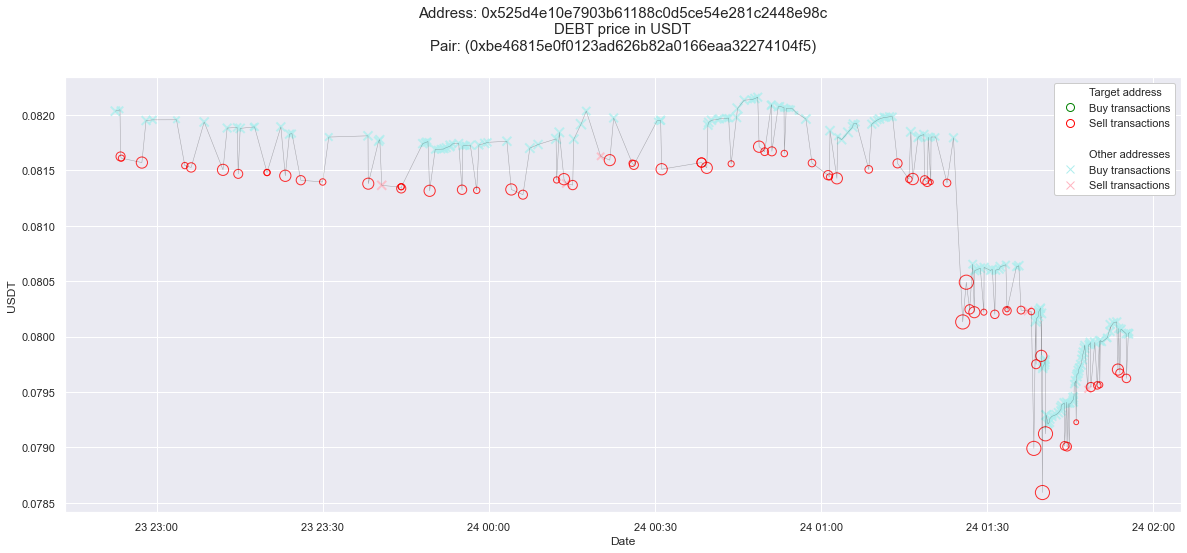

69.19644113300623
1.7529102408984691
66.81829168278033
2.955326885592971
263


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x525d4e10e7903b61188c0d5ce54e281c2448e98c,is_buying


263
122
['0x37f052847e90f32d38e5a43e2b2944b3f37f7dde'
 '0xbd4665bb5ac9d2036141cf282596ed53c80ab686'
 '0x525d4e10e7903b61188c0d5ce54e281c2448e98c'
 '0xd8b592ad8a4c2c47010f7a9fb8b91d1672dd44c3'
 '0xb2ec00c86cb4da93c9d6cd000591946a30727b2d'
 '0x33113d9162730ee60810c223ef8ddf76ff8e86e1'
 '0x3e0c11b441745bcdb8ec2ab3828d1d3f2e997213'
 '0x8a38e41fb31f0a4a7aabd2c7377389c65b83b4bb'
 '0x308f4c3b074945453e4c895e12ec695555c4f6a3'
 '0x8b98c469d648ce1a24314dc058d2115af8f9ec13'
 '0x4236f076325839c61478bcc4879cb7b2bb2a926a'
 '0x02d6a190fb52e92aa6f8cbe88179e9f37a2f099c'
 '0xc101f441a046a897af4c6aecb9cae06b20d9ec82'
 '0x3bca2b6d36df6c436545617654c894302a7994a4'
 '0x76cd14dee518c8411fbaaae0e532257997b1d6f1'
 '0xe9b47c7f843063d8b81b6ed06701b0e6c9d19e0a'
 '0x5707bfbc41dbabba0245513b0cbae9f92a72cea8'
 '0x45f9b85956d84ae9a1b040f981b20ff87fdce9f0'
 '0x2892f7aa86885017a8b424628f7fede92b7777d6'
 '0x068701d7f98291ec0555636c42c335dbe9dd519e'
 '0xbfb2d6c9d4f4c6cd6be1564efca49f2975665653'
 '0x4f6598cabb0ddc29842da9

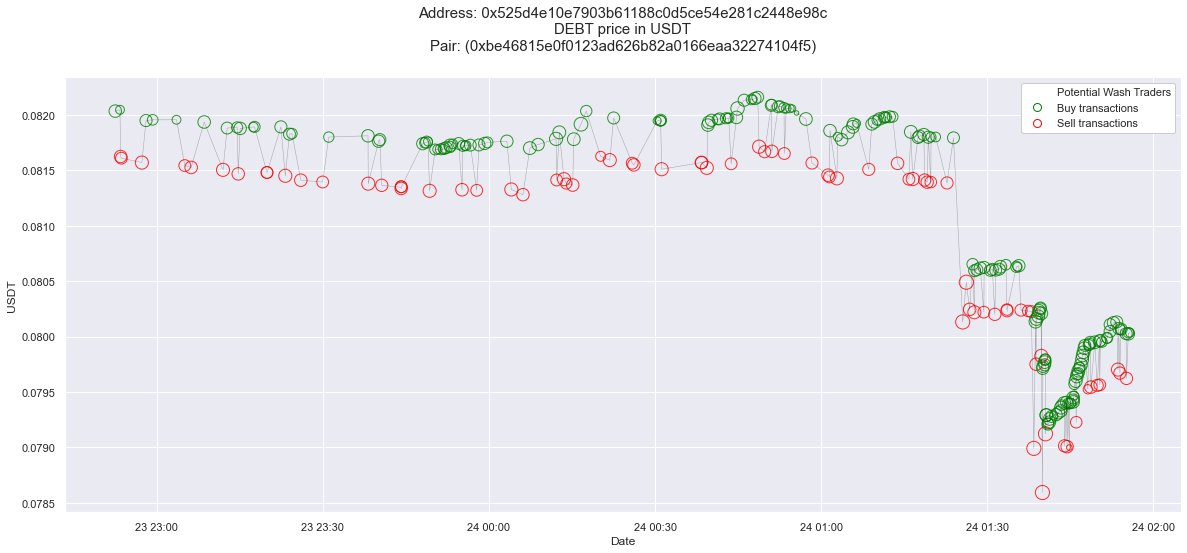

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x525d4e10e7903b61188c0d5ce54e281c2448e98c,is_buying
233,0xbe46815e0f0123ad626b82a0166eaa32274104f5,0x00000000000000000000000000000000000000000000...,23315910,0x89655884a573a187f00bb2e75aa4b42bcbf3dc34245a...,1669243952,5000000000,210852,12,0xfe1730ab8a0f096c3f62e5e60879d00c6f3c3d64f0b4...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x37f052847e90f32d38e5a43e2b2944b3f37f7dde,2022-11-23 22:52:32,0,5470003996,666808248524818161489,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.082033,12.190270,69.175834,False,True
502,0xbe46815e0f0123ad626b82a0166eaa32274104f5,0x00000000000000000000000000000000000000000000...,23315927,0x61cea5b96ef4ed1e18c7dc0ab5090403de149bcff9c0...,1669244003,5000000000,210828,98,0xd1af3cf89dcb0609e77e246929756fea2ef1690761b7...,48,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xbd4665bb5ac9d2036141cf282596ed53c80ab686,2022-11-23 22:53:23,0,22017158,2683550698307515086,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.082045,12.188452,61.218849,False,True
524,0xbe46815e0f0123ad626b82a0166eaa32274104f5,0x00000000000000000000000000000000000000000000...,23315929,0xad611243bc9b2070d45e432d9d033db576a8d477fb36...,1669244009,5000000000,119820,108,0x20b40cb135149435fe592cbda45000cc64e30c484638...,41,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x525d4e10e7903b61188c0d5ce54e281c2448e98c,2022-11-23 22:53:29,639040000000000000000,0,0,5216077624,2.3224,170.0,2.0,1.281187e+23,0.097222,False,0xbe46815e0f0123ad626b82a0166eaa32274104f5,-2.225995e+21,-1.815470e+10,1026752070684,1095371252965,2122123323649,13479075301175618,128118729583333333183323,128118743062408634358941,3.381670e-18,2.986766e-08,True,0.081624,12.251351,69.114468,True,False
601,0xbe46815e0f0123ad626b82a0166eaa32274104f5,0x00000000000000000000000000000000000000000000...,23315932,0x6d36e10597c5973e712b1a61e30a9c78038929f92aa6...,1669244018,5000000000,119808,350,0xdcb14d73af7260cba1a76f1a41b520a98d7f77497206...,79,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x525d4e10e7903b61188c0d5ce54e281c2448e98c,2022-11-23 22:53:38,187856000000000000000,0,0,1533067636,2.3224,170.0,2.0,1.281187e+23,0.097222,False,0xbe46815e0f0123ad626b82a0166eaa32274104f5,-2.225995e+21,-1.815470e+10,1026752070684,1095371252965,2122123323649,13479075301175618,128118729583333333183323,128118743062408634358941,3.381670e-18,2.986766e-08,True,0.081609,12.253602,67.348189,True,False
1570,0xbe46815e0f0123ad626b82a0166eaa32274104f5,0x00000000000000000000000000000000000000000000...,23316006,0x02229c2176535c33bfa2b0c49d0dfc13a7482fa329bf...,1669244240,5000000000,119820,133,0xa21c353d9a714f9528929c52409da759d8efdf81b5db...,42,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x525d4e10e7903b61188c0d5ce54e281c2448e98c,2022-11-23 22:57:20,2011720000000000000000,0,0,16409375277,2.3224,170.0,2.0,1.281187e+23,0.097222,False,0xbe46815e0f0123ad626b82a0166eaa32274104f5,-2.225995e+21,-1.815470e+10,1026752070684,1095371252965,2122123323649,13479075301175618,128118729583333333183323,128118743062408634358941,3.381670e-18,2.986766e-08,True,0.081569,12.259577,70.768920,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51959,0xbe46815e0f0123ad626b82a016

1
Swapper address: 0x581478e4b12b7cf981dad77eda039a56cbfcc512
Pair contract address: 0xc67e70025fe4727c58598c560eb2f25b64d3c7e7


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
1,1.25,True,False,True,0.32,-40.687879,NaN,NaN,NaN,2.483747e+22,NaN,NaN,NaN,146.102761,NaN,NaN,NaN


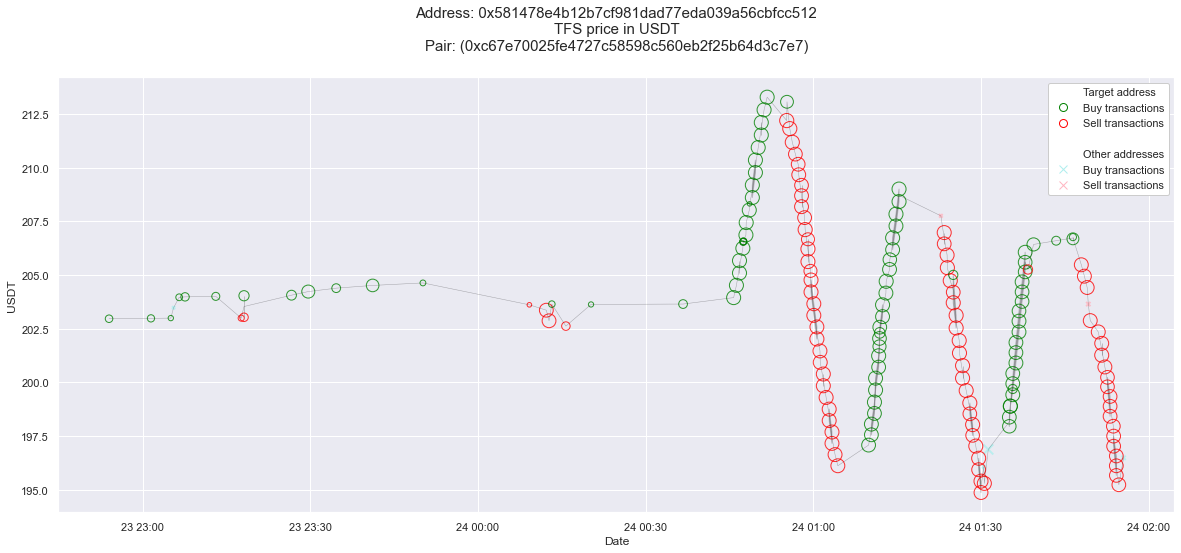

74.12828093369488
1.7708558425912972
75.98365919730351
0.35219881973889466
176


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x581478e4b12b7cf981dad77eda039a56cbfcc512,is_buying


176
3
['0x581478e4b12b7cf981dad77eda039a56cbfcc512'
 '0xe7a468d4e1ef1bd5199a9799c9474e615fbeaaee'
 '0xb7499a92fc36e9053a4324affae59d333635d9c3']
5.7902311739435925e-09
8.036523384500855e-06


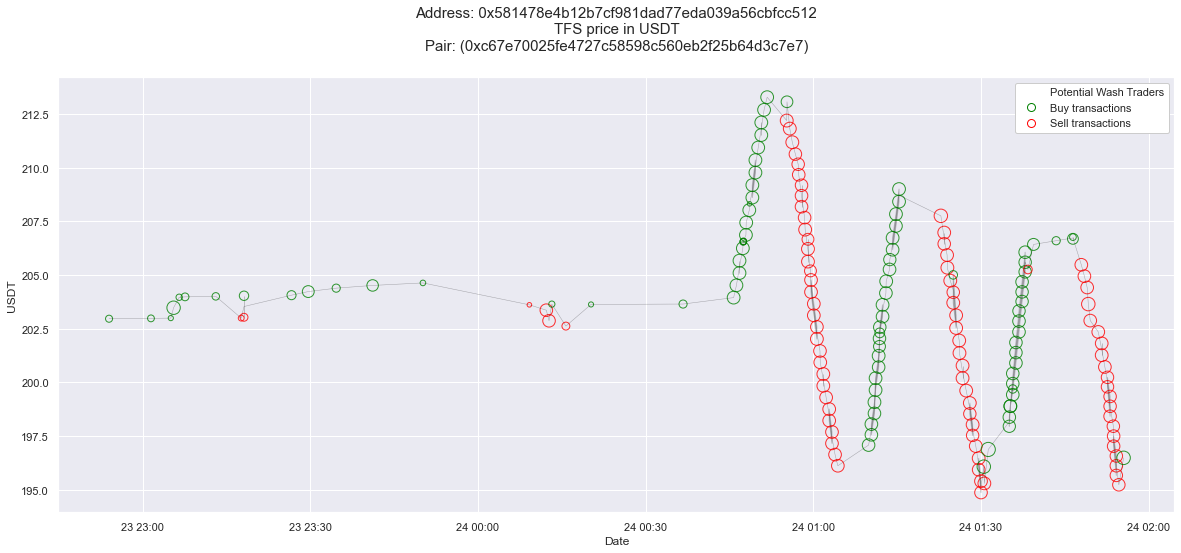

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x581478e4b12b7cf981dad77eda039a56cbfcc512,is_buying
696,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23315939,0x30870bb9408dd4b0cbe364854d85dbdc1c1541e21cdd...,1669244039,5000000000,119530,178,0x2bc9f1804b3ac2b61c0ce8dd88fa8cdf98cf6899f5de...,58,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x581478e4b12b7cf981dad77eda039a56cbfcc512,2022-11-23 22:53:59,0,1218112000000000000000,6001531821744304480,0,2.3224,170.0,55.0,1.245494,0.323529,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,-1.569486e+20,-3.195681e+22,2797214798823983647455800,2246002222100000000000000,5043217020923983647455800,10986682815904259759841,13850786500000000000000,24837469315904259759841,0.000008,5.790231e-09,True,202.966848,0.004927,70.052227,True,True
2608,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23316089,0x6a40980fab177ee2e99a670553e02bd2cfb869416ddd...,1669244489,5000000000,119542,118,0xf4c8dbc9297cec948fad185e5c79c8b95a746e6ff46b...,56,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x581478e4b12b7cf981dad77eda039a56cbfcc512,2022-11-23 23:01:29,0,1099859000000000000000,5418455068249372296,0,2.3224,170.0,55.0,1.245494,0.323529,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,-1.569486e+20,-3.195681e+22,2797214798823983647455800,2246002222100000000000000,5043217020923983647455800,10986682815904259759841,13850786500000000000000,24837469315904259759841,0.000008,5.790231e-09,True,202.983874,0.004926,69.904899,True,True
3513,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23316160,0xad14892332fbb6e22804d10bc7d7dc51c589326716b4...,1669244702,5000000000,119530,68,0x397791c845ae0187a714dddef294a6b7781d1adbe004...,30,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x581478e4b12b7cf981dad77eda039a56cbfcc512,2022-11-23 23:05:02,0,601720000000000000000,2964190846801092165,0,2.3224,170.0,55.0,1.245494,0.323529,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,-1.569486e+20,-3.195681e+22,2797214798823983647455800,2246002222100000000000000,5043217020923983647455800,10986682815904259759841,13850786500000000000000,24837469315904259759841,0.000008,5.790231e-09,True,202.996376,0.004926,69.034744,True,True
3659,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23316170,0xc9cf53ba146daf91bca12504551866e99727f5b64c65...,1669244732,5000000000,119554,29,0x5b36793ad35039c311022463059430a523c1bb5affb2...,7,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe7a468d4e1ef1bd5199a9799c9474e615fbeaaee,2022-11-23 23:05:32,0,65208002468407295846614,320465279619781576380,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,203.479149,0.004915,75.794540,False,True
3915,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0x00000000000000000000000000000000000000000000...,23316190,0x38f65f4d56060dd182a21517a98c3047f4a16641db12...,1669244792,5000000000,119530,216,0xf5b159f1b8447661021eceeb44b54281f91fd325dfa5...,97,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x581478e4b12b7cf981dad77eda039a56cbfcc512,2022-11-23 23:06:32,0,919240000000000000000,4506816635435718083,0,2.3224,170.0,55.0,1.245494,0.323529,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,-1.569486e+20,-3.195681e+22,2797214798823983647455800,2246002222100000000000000,

2
Swapper contract: 0x020e878018bccebd9459e8f098233b7df1964b7b
Pair contract address: 0xa527035b53961f83009ef010ae1600afa89b1438


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
2,3.391007e+21,True,True,True,0.02,-46.296046,NaN,NaN,NaN,1.342489e+21,NaN,NaN,NaN,8.33844,NaN,NaN,NaN


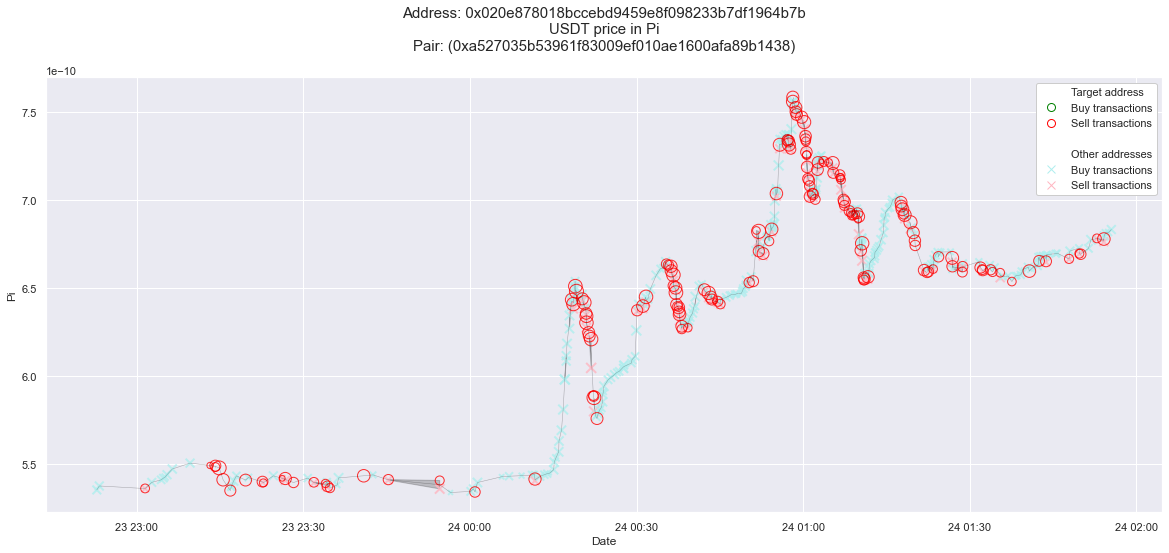

63.388225449024496
1.606372180053236
67.4548900543334
2.1790595006792453
522


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x020e878018bccebd9459e8f098233b7df1964b7b,is_buying
293,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23315915,0xc57f2c3a84357e10bf1c7a6d57c2d79e340188df1d1e...,1669243967,5000000000,210084,71,0x11577fa37a074ff953ac837e0aa527b02018a550b66c...,39,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2c4659e29cce54d323f3843dcf2def70e1fbb873,2022-11-23 22:52:47,0,150000000000000000000,280267900079051834113,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.352022e-10,1.868453e+09,68.543797,False,True
444,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23315924,0x5c42f8957419de8963c25ca939cf45eb6e5d32d3cf0d...,1669243994,6000000000,240084,45,0xcf17e930534c929a43925f0979ee52f5d129272be423...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x38308b7c7f230a4ca87b946d83e1a3b9cc0db222,2022-11-23 22:53:14,0,197000000000000000000,366537163679224465526,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.374626e-10,1.860595e+09,68.933073,False,True
2901,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316113,0xe3559c49d0704adcffec1d532d4339cb6e9e7de47b1e...,1669244561,5500000000,303632,48,0xfa3e1152f87f647310af64f87f5b454825cfa8474057...,14,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xbc347e7291a2782873c76b05174c08eedf1907a7,2022-11-23 23:02:41,0,149550000000000000000,277200010602654483351,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.395021e-10,1.853561e+09,68.531953,False,True
3631,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316168,0xf491acd2b2f950064346a29fa6735489d8e47fe7e287...,1669244726,5000000000,225108,177,0xfffe71daad97332bd2a7cb8055fb81231736c9f87417...,47,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xdc160b1fdde752ee96a65dfa422fdc354a05eef0,2022-11-23 23:05:26,0,195417702992988312708,359318915876095142271,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.438559e-10,1.838722e+09,68.910365,False,True
3868,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316187,0x873a9d78863b56fccfddbd96502e7cdf38d93183c063...,1669244783,5500000000,288632,62,0x996df24fd96101ad105f7685bbff6fc24bc8330e57be...,15,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xbc347e7291a2782873c76b05174c08eedf1907a7,2022-11-23 23:06:23,0,299100000000000000000,546697187870484351846,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.471036e-10,1.827807e+09,69.518874,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49618,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23319354,0x8db9390386eaf4ef290e09bcff90037a8e7fb5f1ab98...,1669254484,5000000000,225084,264,0x0c7bcb74836fdf670b3a678d6a65f7f9aaf9e10c4cee...,87,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2ac8c6fad0d21ec2ba8a01c6eaf5fa28e34b0957,2022-11-24 01:48:04,0,200000000000000000000,298011615561131049390,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.711148e-10,1

388
174
['0x020e878018bccebd9459e8f098233b7df1964b7b'
 '0x84f755ce278000e6ee0637aaf404040dd828a069'
 '0x3e3b0decc63ddb0e2425c863ef096427a0f41d47'
 '0x38c977c249b4bff3151d67bb8a682a0b0a5059a8'
 '0x9d2abbf26e4b952f888894b63cedb0814041eef1'
 '0xef3cb8478f95a6e55976dbeaae52f2f41fa3106b'
 '0x373812b8bab26026b38b47202cef72789f756296'
 '0x92592850dd1193af4b079d20624c3f8dd0a057d6'
 '0xab4745583145b1d72b656eacddf936b444b22570'
 '0x6f5ac65ca70f2a44d73c8f711cb2bdf425d9f304'
 '0x2858aad4f0301717d981176334594bd1af947311'
 '0x405ff01e5dd86567e9eee0ba8372db6caa3656a5'
 '0x7345a3434f0c0510d4ce6a02fc5470456aab7d80'
 '0xf438587f3590a8656b53dea543336e79cc79f039'
 '0xa50c00fd3e6fe8e417dc1b5deab9d8a7ac0c0b24'
 '0xdcb6c2d98bfc937757a44380d945c0e3cd4d83b5'
 '0x2f53d52a822dac3b09b9e4a225ca15bb413c5d04'
 '0x37689848690b6b5449ef23b65f48e49d68337a22'
 '0x86942533fb9edacb99ddef55abbcbe841302be5d'
 '0x6cbd7d73362f6971367ccac8279d0380fa3110b3'
 '0x577d6784a610fdc16ec8a9fb1b8c917be2749083'
 '0x6b149e7442c63a87c703a6

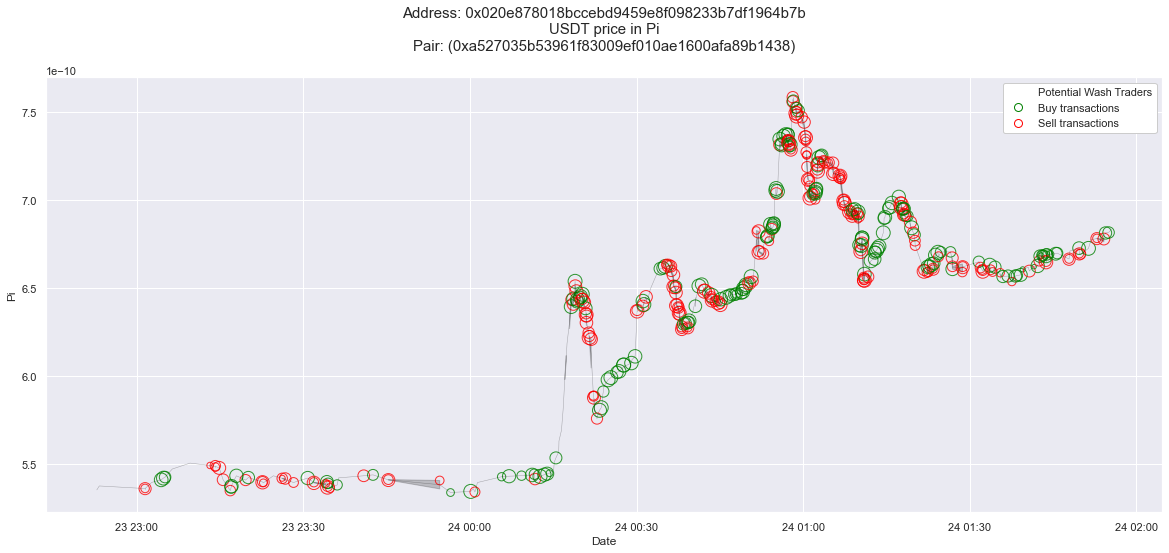

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x020e878018bccebd9459e8f098233b7df1964b7b,is_buying
2606,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316089,0x6a40980fab177ee2e99a670553e02bd2cfb869416ddd...,1669244489,5000000000,483293,88,0x1c7b048878fc9aaa38ddc77efb43a1c3ba3b13679d66...,39,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x020e878018bccebd9459e8f098233b7df1964b7b,2022-11-23 23:01:29,2126120037852441772,0,0,1139712806182270202,2.1995,161.0,12.0,3.391007e+21,0.024845,True,0xa527035b53961f83009ef010ae1600afa89b1438,4.616409e+20,2.468958e+20,1342488828370260693501,0,1342488828370260693501,0,2048518452997459367224,2048518452997459367224,2.139298e-09,4.775605e-10,True,5.360529e-10,1.865488e+09,61.502157,True,False
2607,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316089,0x6a40980fab177ee2e99a670553e02bd2cfb869416ddd...,1669244489,5000000000,483293,104,0x1c7b048878fc9aaa38ddc77efb43a1c3ba3b13679d66...,39,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x84f755ce278000e6ee0637aaf404040dd828a069,2022-11-23 23:01:29,29765680529934184808,0,0,15952668672987553319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.359417e-10,1.865875e+09,65.309407,False,False
3337,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316147,0x2154aedec96019320efd1068b2fb347c0743ac4e4631...,1669244663,5000000000,210084,100,0x270b5f9d12d3e331b6099927823019ef6c1d9da9af35...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3e3b0decc63ddb0e2425c863ef096427a0f41d47,2022-11-23 23:04:23,0,71000000000000000000,131251688068818814391,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.409454e-10,1.848615e+09,67.454714,False,True
3459,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316155,0xbd818d7117e64eeb02a0652dc96e3fc9ac012e4a54c7...,1669244687,5000000000,240084,259,0xb047f08cf116b9f7d190506d850d22bbdad6478a6feb...,90,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x38c977c249b4bff3151d67bb8a682a0b0a5059a8,2022-11-23 23:04:47,0,79000000000000000000,145775993947968679762,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.419274e-10,1.845266e+09,67.607050,False,True
3534,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23316161,0x0d53619e42e6d77482a9d7fbcf27e08bf8521519dc74...,1669244705,5000000000,240060,194,0xf9641f269ebdda6ceb4c10224be2b5f2bc3658612bb0...,97,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x9d2abbf26e4b952f888894b63cedb0814041eef1,2022-11-23 23:05:05,0,10000000000000000000,18432801173722460917,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.425111e-10,1.843280e+09,64.624190,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51231,0xa527035b53961f83009ef010ae1600afa89b1438,0x00000000000000000000000000000000000000000000...,23319444,0x73e660bef28a24ebf21daf36d9f87c0e8aed4dc1f27c...,1669254776,5000000000,468305,468,0x42a1ccc13d5b80bf5065e26953671ab5fd8458d90577...,177,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x020e878018bccebd9459e8f098233b7df

3
Swapper contract: 0x597873c70dc1946613d485601c9bdc4608e36f14
Pair contract address: 0x2315faf6aafe06a06c884d04975059e82be08bf7


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
3,1.719516e+29,True,True,True,0.03,-393.619348,NaN,NaN,NaN,1.255434e+21,NaN,NaN,NaN,10.290439,NaN,NaN,NaN


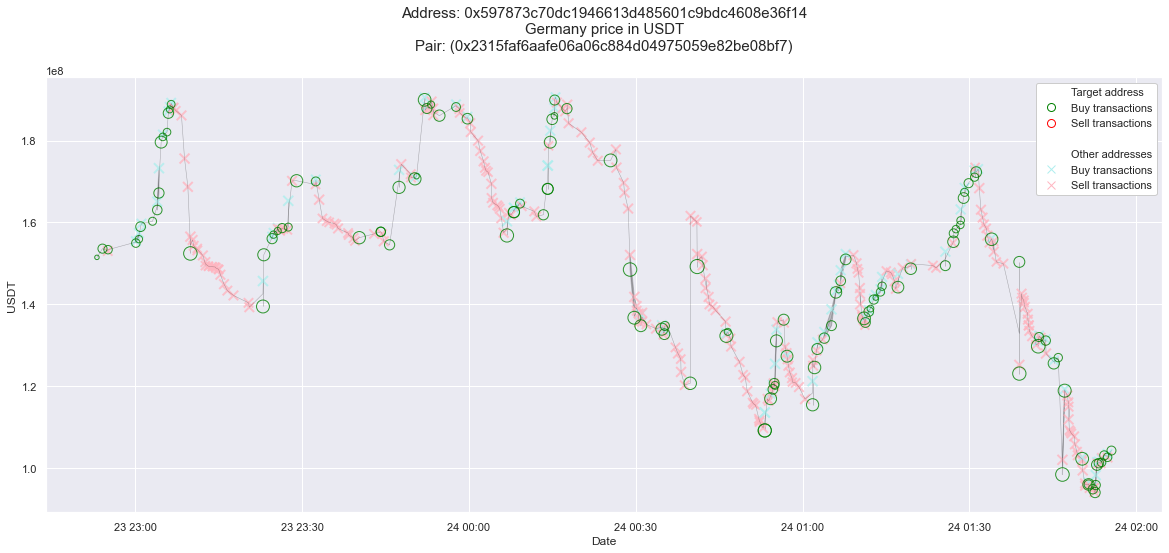

89.24476301710449
1.685472884519651
92.8933088010045
2.427846648182896
445


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x597873c70dc1946613d485601c9bdc4608e36f14,is_buying
2423,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23316073,0x00229a7171e8be9c183fcdd911faad4d8c40d5fe055d...,1669244441,5000000000,636397,331,0xaffeb8f8a832238c83c49f040d43e4de733df9ad0882...,129,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6bc0e603dcfd728859e12a32a923cc1e570b4370,2022-11-23 23:00:41,0,27557778432929816489467211123,175056125068639469599,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.574225e+08,6.352331e-09,94.476446,False,True
3241,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23316139,0xd0321e6add4a30a3be3b5cf7d636313e7c39ba3ed3a1...,1669244639,5010000000,662197,90,0x00fa6ea8be476a074e99bddf3063b41343f90444f5e7...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xd01e27f998e35ca75afa9e0d34b911f922bb828e,2022-11-23 23:03:59,0,36525554784489475586407399646,221246656212358552196,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.650897e+08,6.057311e-09,94.882893,False,True
3316,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23316145,0xbc65fa00d2653b448ecc94e11fb0ee61decadec0c805...,1669244657,5500000000,677209,95,0xb6e84fb1318a606946cf9a31ef2debd7ce1db60c139f...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6aec7542ea5205c3acda96a02410fe2825ee78f6,2022-11-23 23:04:17,0,107175843219543616945143446609,618629866215750631526,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.732471e+08,5.772102e-09,96.435895,False,True
4471,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23316237,0x88ce8bdd7cf3dbacdeb6acfb88fb1cd5076863e4510b...,1669244933,5010000000,394614,61,0xf49191c4945011323707995d69796bf03f5dcc7b73ec...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xdafee95d26e870e89289299aa549ecdb4c102c1e,2022-11-23 23:08:53,500000000000000000000,0,0,87801511484409313138184338151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.756030e+08,5.694663e-09,96.148232,False,False
4595,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23316249,0x92bd56b8feac52b46fa465e84e154676f937667aebeb...,1669244969,7000000000,379590,43,0xffd74a3873fdfac9829a6e40a1fc5addb919f20071bd...,5,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xf9d85850ec43e5da34f3cf92cfb9b2d30097bfea,2022-11-23 23:09:29,200000000000000000000,0,0,33738721986899930461922555840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.686936e+08,5.927907e-09,94.768392,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49164,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23319327,0x1fb2623453cef13a0c4434dcf2feb7344cd8392c8260...,1669254403,5000000000,382530,770,0x571dbbd2a8df2ae83236c341e1bb6517499eff39eae3...,210,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x9da52eebec94eba107dbbb1007018c3dc0ff9b5a,2022-11-24 01:46:43,1000000000000000000000,0,0,102012044169770022520437174762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

370
144
['0x597873c70dc1946613d485601c9bdc4608e36f14'
 '0x64bd9109a9ca778480dbcd25e3855e7cfa60e32b'
 '0xac701337c1f6475d2fcc3ad97c1a11b666f86a50'
 '0x60716964c8a9a6a98250473c7412fff4a7f525fc'
 '0x9cfe7193c64dcedd7ad3408d2b198c0e659310bc'
 '0x10e4cb8e3058a4108a3892477d1ffbc6ce4678eb'
 '0x65d6f4eca5a6e7ffbdbf10f4f132bf352df53150'
 '0x0652bbf5fd1c0f9519f9d3a3e4747021b538e5e0'
 '0x24e019d1151a63c6c6f5d29914b5ce1d9e9c4553'
 '0xcc3a64d61a5318add52fae8ffed54db65bc559f3'
 '0xcc3160477d1550e217207578b201282b5afc8f38'
 '0x7c0c4baf653da96adc46d6316a30092e6a6b7659'
 '0x075dc7ce3c1d2ed127d897d199c8e3cff2a66bf0'
 '0x3ee4ac2cc063a0afa1ec86624cb1129934a8c075'
 '0xf9d85850ec43e5da34f3cf92cfb9b2d30097bfea'
 '0xdc276f3f388263ce80169c8b28fba4fb431030df'
 '0xfddfddfa9b7fd22307ff9e1c2e16b0b8642e7d79'
 '0xe599d6b192d1656bad650824f4aa5ab3a594eb8c'
 '0x43b7347fa7fb9a41c9979689e2e3dcd5021f5707'
 '0xb3c0fea9cfc18d8cdd35a3bfa7d33812170dde54'
 '0x7bf4b66a37a079eef5fb9db47103942384987260'
 '0xb738067db5124203a3cadc

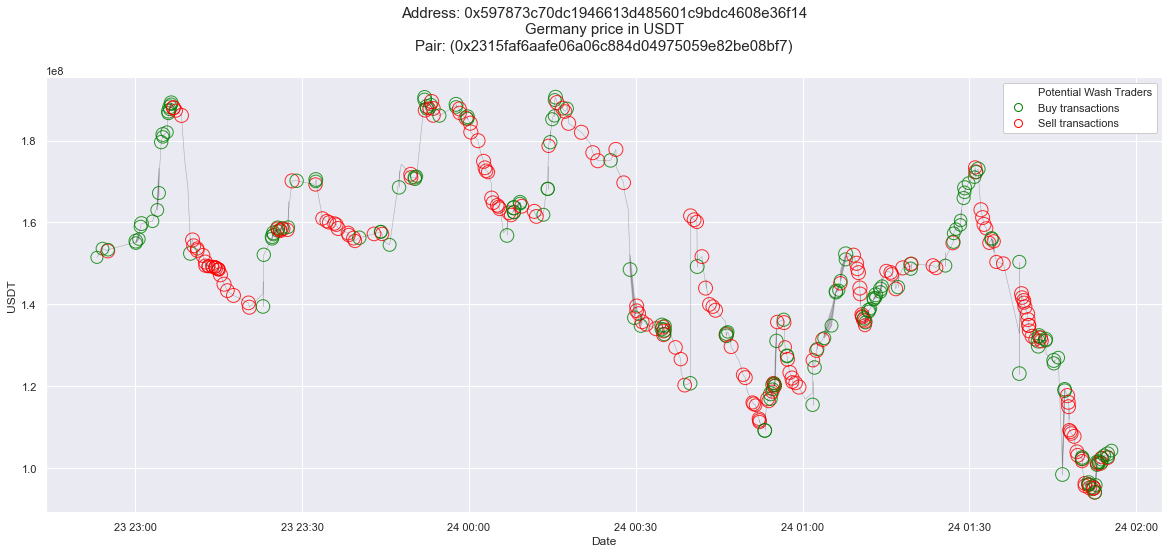

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x597873c70dc1946613d485601c9bdc4608e36f14,is_buying
436,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23315922,0x93ea11e28c9198cb96e939c696bed42c6adea0420741...,1669243988,5000000000,755695,277,0x364b6146c1702aad4ce388a20d830bc1dba6fd246073...,115,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x597873c70dc1946613d485601c9bdc4608e36f14,2022-11-23 22:53:08,0,63012221100130850683425927,416016734257995617,0,1.6667,122.0,2.0,1.719516e+29,0.032787,True,0x2315faf6aafe06a06c884d04975059e82be08bf7,-7.667966e+19,-9.897950e+27,0,171951597877053404218361264297,171951597877053404218361264297,1255433550275623011972,0,1255433550275623011972,0.27401,2.926728e-10,True,1.514656e+08,6.602160e-09,85.703834,True,True
735,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23315942,0x420b5b2cc1ede17fb7d070b16fd15f28e1283ce601dc...,1669244048,5000000000,740719,257,0x2692b5c43da4df4daff2e44894d7b7bc489d0ed9594b...,66,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x597873c70dc1946613d485601c9bdc4608e36f14,2022-11-23 22:54:08,0,370011709628922537661511704,2408999951343859169,0,1.6667,122.0,2.0,1.719516e+29,0.032787,True,0x2315faf6aafe06a06c884d04975059e82be08bf7,-7.667966e+19,-9.897950e+27,0,171951597877053404218361264297,171951597877053404218361264297,1255433550275623011972,0,1255433550275623011972,0.27401,2.926728e-10,True,1.535956e+08,6.510605e-09,88.257701,True,True
975,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23315961,0x86dc1581b403812916dec99e711697b2e4c9c74ad553...,1669244105,5000000000,537294,75,0x43f86b462f98df26642d5cc74ffa2637417254331357...,20,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x64bd9109a9ca778480dbcd25e3855e7cfa60e32b,2022-11-23 22:55:05,55294064571728772468,0,0,8461053754047897441123910923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.530192e+08,6.535127e-09,92.772896,False,False
982,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23315962,0x8dd8d5e57ba233d35cc59953b6ac5b40420468e7344f...,1669244108,6000000000,737803,44,0xd3da2d93c5429de0eedbb6f94fac833ebbbf16436ab9...,17,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x597873c70dc1946613d485601c9bdc4608e36f14,2022-11-23 22:55:08,0,266645330882053444027961992,1738871327268551367,0,1.6667,122.0,2.0,1.719516e+29,0.032787,True,0x2315faf6aafe06a06c884d04975059e82be08bf7,-7.667966e+19,-9.897950e+27,0,171951597877053404218361264297,171951597877053404218361264297,1255433550275623011972,0,1255433550275623011972,0.27401,2.926728e-10,True,1.533439e+08,6.521289e-09,87.785053,True,True
2249,0x2315faf6aafe06a06c884d04975059e82be08bf7,0x00000000000000000000000000000000000000000000...,23316062,0x8d28c6486eca35b19fd8e1d02a97c4d30b395e12a787...,1669244408,6000000000,681397,33,0xa094a47a1748f3df8c754ea389e0ac5ed758eb61dbb1...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x597873c70dc1946613d485601c9bdc4608e36f14,2022-11-23 23:00:08,0,275830581696647555149059078,1780106440727608801,0,1.6667,122.0,2.0,1.719516e+29,0.032787,True,0x2315faf6aafe06a06c884d04975059e82be08bf7,-7.667966e+19,-9.897950e+27,0,171951597877053404218361264297,171951597877053404218361264297,1255433550275623011972,0,125543355027562301197

4
Swapper address: 0x324ec7743a70212299ae82ad674f7547e6b4069d
Pair contract address: 0x58f876857a02d6762e0101bb5c46a8c1ed44dc16


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
4,1.254302e+22,True,False,False,0.0,NaN,NaN,NaN,-0.392321,NaN,NaN,NaN,4.187499e+19,NaN,NaN,NaN,0.615809


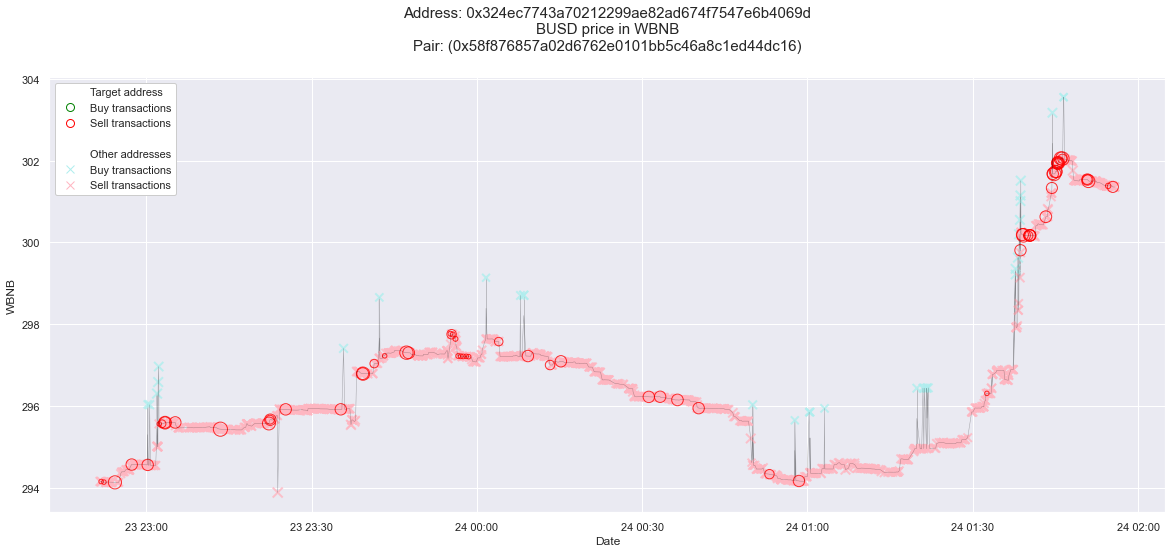

66.30259441531959
2.012764781383629
64.56131835304664
4.073857262792198
1374


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x324ec7743a70212299ae82ad674f7547e6b4069d,is_buying
2705,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23316098,0x163df9bfa8a39f96c0176fb6c55f4f55e05faa10f273...,1669244516,10000000000,194836,31,0x21e255b6dd45fda3e81ecaf91da8b3f687ea99a38b49...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xbacaaabb5ef50717f656d74ba448fb15c1d12408,2022-11-23 23:01:56,0,54686045856051426741445,184557890786947516644,0,0.1503,11.0,0.0,3.688887,0.0,True,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,-3.233695e+18,-9.612530e+20,56406505041675761936052,208080107882589030750432,264486612924264792686484,696634484088107017660,189631854893908218840,886266338982015236500,4.214677e-07,2.066107e-10,False,296.308360,0.003375,75.538452,False,True
2755,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23316102,0x661f3e6847e59a1c70e81ef3cbdf10c0492a7e29e630...,1669244528,10000000000,192200,8,0x4cd68c09b586836bd28b5ba058d3b287e7fbd07b9f2d...,5,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xbacaaabb5ef50717f656d74ba448fb15c1d12408,2022-11-23 23:02:08,0,28822966427318945319050,97180894463373633870,0,0.1503,11.0,0.0,3.688887,0.0,True,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,-3.233695e+18,-9.612530e+20,56406505041675761936052,208080107882589030750432,264486612924264792686484,696634484088107017660,189631854893908218840,886266338982015236500,4.214677e-07,2.066107e-10,False,296.590874,0.003372,74.614493,False,True
3595,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23316166,0xd40d46cfd1c78c21980e5a0ead48270afeddff12b4c1...,1669244720,5000000000,134284,45,0x826e213781c587b3fa73a8eb4f85d4c66260f7331e01...,15,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xaf8e4a38bfed672909ca6629e19d698b5111dae1,2022-11-23 23:05:20,65000000000000000000,0,0,19209765005278099244251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,295.534846,0.003384,74.029131,False,False
6657,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23316428,0x7aaded0201185273e4e0392f209c59d209c4be122581...,1669245506,5000000000,107200,218,0x850a3a8a0360023652bff2d62f5c68b28e96edbf8f50...,80,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xd4e6995f196229c35df49d5f4aa8059cf01aab5c,2022-11-23 23:18:26,25000000000000000000,0,0,7388513734077636174446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,295.540549,0.003384,72.650647,False,False
7919,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23316536,0x6eb95b22a17442725f63538c254a86433af9caec6d1e...,1669245830,5000000000,119284,52,0xabf4b73f1a391032b632f853a3109bcb39f7802c59f0...,46,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xc72aed14386158960d0e93fecb83642e68482e4b,2022-11-23 23:23:50,1800000000000000000000,0,0,529004881113614937164382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,293.891601,0.003403,78.812528,False,False
11256,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23316799,0xbad729c15c6cc136c4c5931c5b7168af15ce35ebc437...,1669246628,7000000000,373287,13,0x0e0061adaf8ae2e57e3b4104217b6316fc96704fee3f...,5,Swap,0x10ed43c718714eb63d5aa

1343
823
['0x33969581d5de65c3948cd604fc6f9c69943955d8'
 '0xe093f019e45218949bf210696869665eee186fc3'
 '0x324ec7743a70212299ae82ad674f7547e6b4069d'
 '0x7a051697c7512b57271bfffc4c73f329853a6eb5'
 '0xa03b30d68ecdf26d6ab3df8558d322a0f3f1cc1d'
 '0x9f8bb16f49393eea4331a39b69071759e54e16ea'
 '0xba4d77f2a4124227fb2799fab0f48d2db1c51eb7'
 '0x2ed46d10cf63c7a4baf8c665902944a64fa6374e'
 '0x6b5c1190f9d6a684c3a8fee9e5e7679696fea871'
 '0x4470c5648767ebc72b3619b0d3fd88957dbcb222'
 '0xabf46626e7f46e68d692d946fa7b8190b07191ac'
 '0x48ee7b2ef0688575be9cbc2bcbe7c7ae4b10bf24'
 '0x5df82ac19c6d9f91c116cf3f5aa9f7c95852c73c'
 '0x44ea309d694f6f94f2febd1c0f0e63c7b5ee2263'
 '0x1cdcad04e4b0029cbc34fd7f77a6e427194fd442'
 '0x49b2d3dc01fdf2fe5bccd1dc4d05bae7b6edfec4'
 '0x925030586aee5426e5a828c5c1b595727353dada'
 '0xc6e9f65e25a218e805f1d8d5149af8977fb6a004'
 '0xc7ebdb74395ba5c6c98bbe411e3505aea3f971a4'
 '0xceb5a95bc888f35cae196c3c27c3eeb34a6c562e'
 '0x5e22801119e85a1767a544b304321ddf7a69f212'
 '0x43bd06e6e905805fa1266

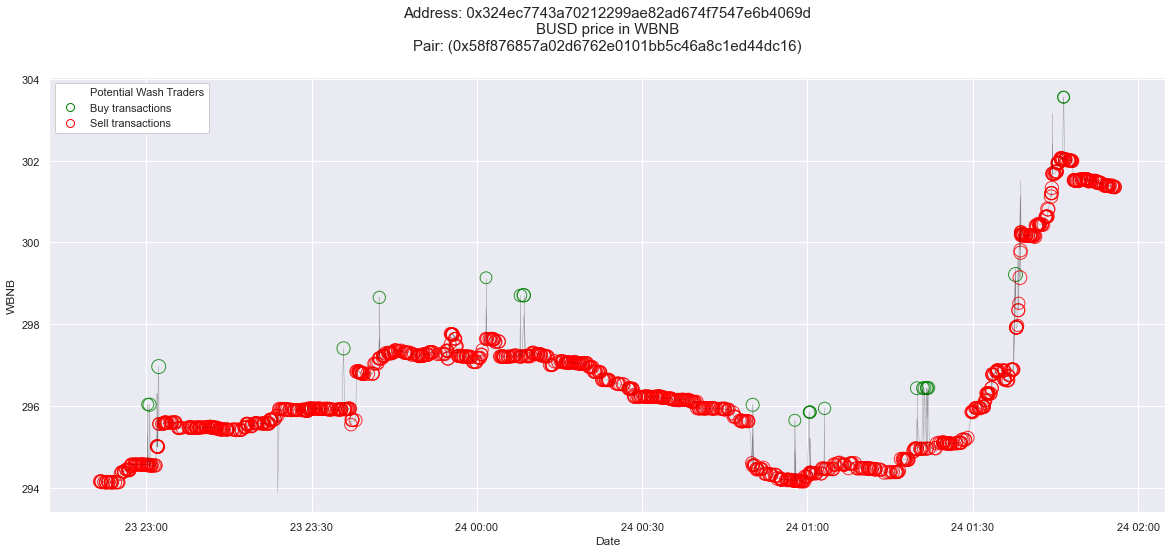

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x324ec7743a70212299ae82ad674f7547e6b4069d,is_buying
21,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23315891,0x313d21b0429f15f619a4f572a212be554bdbcd79318d...,1669243895,5000000000,134272,47,0x2abd373eeaf363903f22702c959e823bbc0856e5450b...,25,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x33969581d5de65c3948cd604fc6f9c69943955d8,2022-11-23 22:51:35,391086280759461712,0,0,115042787074882880665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,294.162165,0.003399,66.645629,False,False
57,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23315894,0x715859453c230157175d8dd6109f850667c9e4805720...,1669243904,5000000000,119272,87,0x15a5ae704feeea983a13c78309e74213a2ad02a9ac23...,44,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe093f019e45218949bf210696869665eee186fc3,2022-11-23 22:51:44,800000000000000000,0,0,235328742489367693123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,294.160928,0.003399,67.678136,False,False
60,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23315895,0x7a551e32bbfdd922db5c869916a449cbda95b1186090...,1669243907,5004999999,176027,29,0xc3473ac6537ec04ea9af3725a3bf0951eaf1941dd63d...,15,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x324ec7743a70212299ae82ad674f7547e6b4069d,2022-11-23 22:51:47,30293724845088773,0,0,8911204053702453914,1.2295,90.0,5.0,1.254302e+22,0.0,False,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,-4.720394e+17,-1.425268e+20,17040862940143799970769,95121930000003997820000,112162792940147797790769,591304343979459065859,280911078288296649319634,281502382632276108385493,1.787349e-07,6.562520e-08,True,294.160064,0.003400,62.955222,True,False
87,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23315897,0x0a0c252ab5d7a7a205024ff110c122db5e7bb55e8d73...,1669243913,5000000000,241885,93,0x18e0d30ff1ecca88b5151192e94c79a89b4cf1d94f83...,37,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x7a051697c7512b57271bfffc4c73f329853a6eb5,2022-11-23 22:51:53,6697587550612409685,0,0,1970116627226653321859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,294.153173,0.003400,70.743667,False,False
169,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23315905,0xd7c6d16ca7904258631bf7cdc69bfe888c883e727001...,1669243937,5004999999,176027,189,0x0b4619cf7a66f74ca84b12751ce81d00787bf663938c...,165,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x324ec7743a70212299ae82ad674f7547e6b4069d,2022-11-23 22:52:17,30021601710169655,0,0,8830740808635024462,1.2295,90.0,5.0,1.254302e+22,0.0,False,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,-4.720394e+17,-1.425268e+20,17040862940143799970769,95121930000003997820000,112162792940147797790769,591304343979459065859,280911078288296649319634,281502382632276108385493,1.787349e-07,6.562520e-08,True,294.146225,0.003400,62.942137,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52081,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0x00000000000000000000000000000000000000000000...,23319485,0xc60453350

5
Swapper address: 0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64
Pair contract address: 0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
5,1.99,True,False,True,0.01,NaN,NaN,NaN,0.004612,NaN,NaN,NaN,1.068329e+18,NaN,NaN,NaN,0.013697


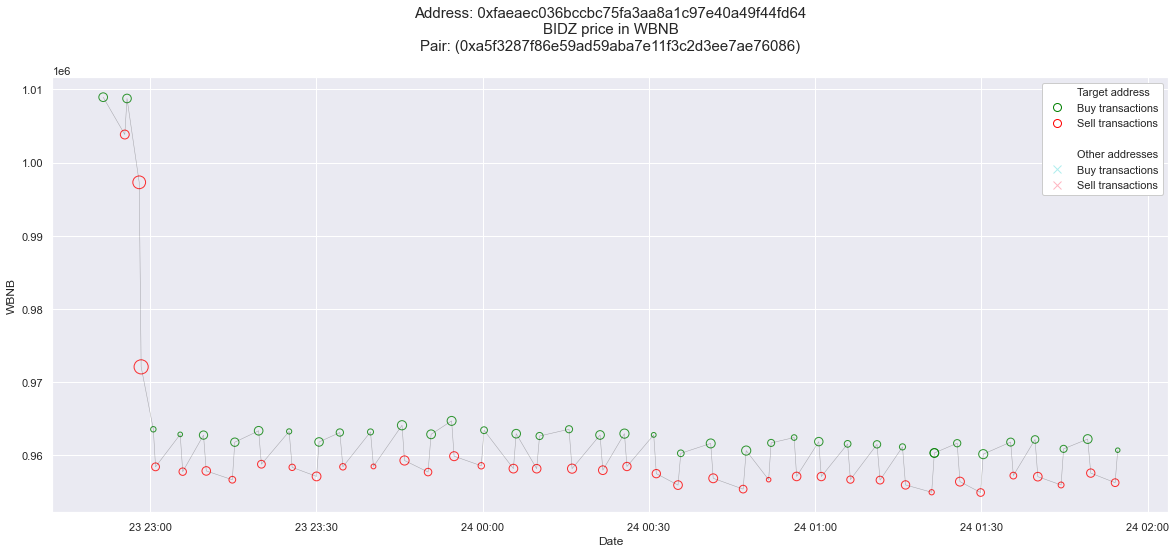

72.90620657162602
0.9470105572487294
nan
nan
78


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,is_buying
1728,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23316020,0x3138d42b158be7409d3921e99168a9de67e2066c8ff8...,1669244282,5000000000,127375,115,0xb20b7da1014229c35f70f5b534279963dce50c148494...,46,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 22:58:02,100271374401689161,0,0,100000000000000000000000,1.0656,78.0,0.0,1.994439,0.012821,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,3.835127e+15,3.692364e+21,688686373863000000000000,345303346216000000000000,1033989720079000000000000,357752032989531162,710576595770109152,1068328628759640314,0.000002,2.490539e-13,True,997293.600459,0.000001,76.404348,True,False
1834,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23316027,0x2975666adb0f1f93fd3477285e6c0b347b05013d97be...,1669244303,5000000000,127375,291,0x4baec7e911c74584d357083f2183b1ed0980f0b86b35...,112,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 22:58:23,257182652270031554,0,0,250000000000000000000000,1.0656,78.0,0.0,1.994439,0.012821,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,3.835127e+15,3.692364e+21,688686373863000000000000,345303346216000000000000,1033989720079000000000000,357752032989531162,710576595770109152,1068328628759640314,0.000002,2.490539e-13,True,972071.785532,0.000001,77.726276,True,False


76
1
['0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64']
2.49053945536209e-13
1.647694820641673e-06


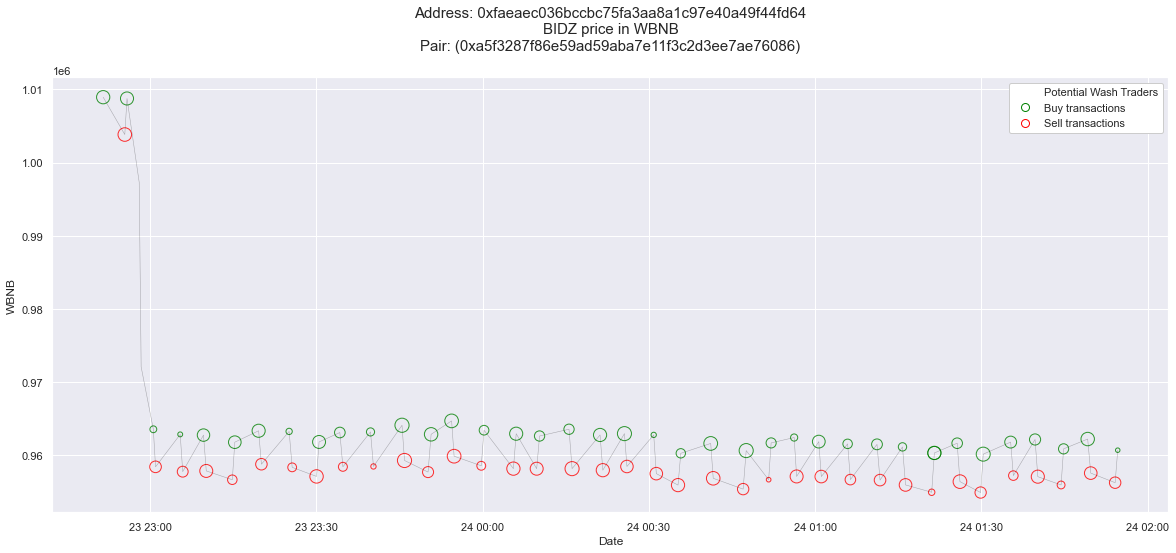

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,is_buying
17,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23315890,0xe20f597d440309fbee7c8e5ff3d95896beff12f592af...,1669243892,5000000000,120473,254,0xb41f4bef049cedb494a6f8d71576e163b6b94daaed47...,91,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 22:51:32,0,12004878469000000000000,11898629389302459,0,1.0656,78.0,0.0,1.994439,0.012821,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,3.835127e+15,3.692364e+21,688686373863000000000000,345303346216000000000000,1033989720079000000000000,357752032989531162,710576595770109152,1068328628759640314,0.000002,2.490539e-13,True,1.008930e+06,9.911495e-07,73.346040,True,True
1061,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23315968,0x59562be2071222756a651f69e879b5c9e90b0c2d2df5...,1669244126,5000000000,112947,187,0xbdb0d1c6f55eb227f35cf4c7a41a71a7690dd258096d...,62,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 22:55:26,12865387020185962,0,0,12914599521000000000000,1.0656,78.0,0.0,1.994439,0.012821,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,3.835127e+15,3.692364e+21,688686373863000000000000,345303346216000000000000,1033989720079000000000000,357752032989531162,710576595770109152,1068328628759640314,0.000002,2.490539e-13,True,1.003825e+06,9.961894e-07,73.451422,True,False
1191,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23315976,0xe712e69c4540c845cf5323f9361eaebf7ad733ac0587...,1669244150,5000000000,120473,298,0x46ee2a5b7b32b826b91d551060c3271c22bbece1b05a...,130,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 22:55:50,0,11464020925000000000000,11364546009560241,0,1.0656,78.0,0.0,1.994439,0.012821,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,3.835127e+15,3.692364e+21,688686373863000000000000,345303346216000000000000,1033989720079000000000000,357752032989531162,710576595770109152,1068328628759640314,0.000002,2.490539e-13,True,1.008753e+06,9.913229e-07,73.279533,True,True
2391,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23316071,0xc8c0760de55e6bcb48eb7ad39ceaf7196678c1f0b754...,1669244435,5000000000,120461,334,0x867febb315d0df0a26144c56f97ecffad623022f8a62...,117,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 23:00:35,0,3877138734000000000000,4023847984025315,0,1.0656,78.0,0.0,1.994439,0.012821,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,3.835127e+15,3.692364e+21,688686373863000000000000,345303346216000000000000,1033989720079000000000000,357752032989531162,710576595770109152,1068328628759640314,0.000002,2.490539e-13,True,9.635401e+05,1.037840e-06,71.715484,True,True
2507,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0x00000000000000000000000000000000000000000000...,23316079,0x2b588ab92ed8557fe2a7ac1507848ec9681fd5e0645b...,1669244459,5000000000,112947,467,0xde4e2a9a77d8808e2c43a02cb2f72262c7bb6e0771e6...,161,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,2022-11-23 23:00:59,8772693734457405,0,0,8407813669000000000000,1.0656,78.

6
Swapper address: 0xca83b78554b19b361a54bd197cd58c62bd3b4c6c
Pair contract address: 0xdc96750446e40e1d79d149e2c70191d749d7c65c


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
6,3.597779e+19,True,False,True,0.46,NaN,NaN,NaN,1.381045,NaN,NaN,NaN,2.632907e+19,NaN,NaN,NaN,0.370832


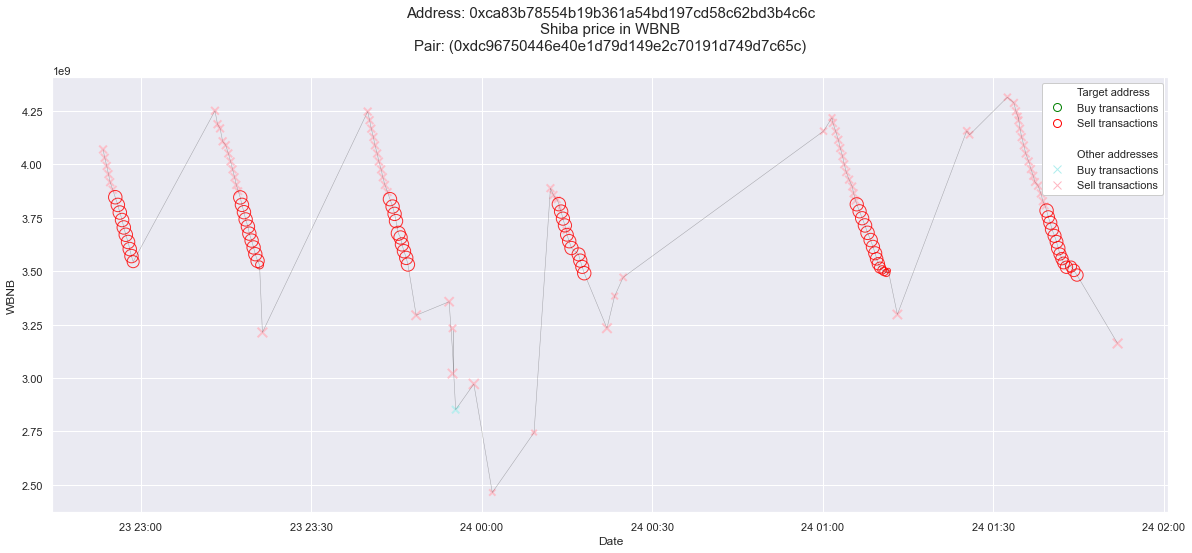

58.71397638707316
0.6479094783253663
58.931091076288375
1.8209272572270807
151


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xca83b78554b19b361a54bd197cd58c62bd3b4c6c,is_buying
7368,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23316487,0xecd4ed692461ab5e3e91ab6c3f7e2a76164c1c79b49b...,1669245683,5000000000,128472,98,0x887b667065af77048df6f2cfded25650156be1aabfd7...,34,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x26c0a6baffdd113a948ae95f91ccf4c1f7db0192,2022-11-23 23:21:23,8867850000000000000,0,0,2849194147339728832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.212948e+09,3.112406e-10,63.345242,False,False
14078,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23317005,0x8d8e169c557de1991daf308a3c50efc92e14aac01d02...,1669247307,5000000000,128472,200,0xc4a96c5abaaf4b68926572b41841957ad8bb56800bd5...,65,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x74deb4388211953cf876513c5bb7837f78d4a93c,2022-11-23 23:48:27,6000000000000000000,0,0,1976183289447367032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.293639e+09,3.036156e-10,62.790404,False,False
15505,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23317121,0x6afaf939302142a3fc6df4b1041c1d4f853c64218558...,1669247655,5000000000,128472,189,0x8e46738c6bac6b0701974f66a9d519053c5b9fe55445...,125,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xdeae0de1654faaffc22d3f5283864c54c1188f88,2022-11-23 23:54:15,4000000000000000000,0,0,1342864014133202134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.357160e+09,2.978708e-10,62.212319,False,False
15683,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23317133,0x5079f25fb7fb4dfae6f7463f738f2b18dbd0406ed67d...,1669247691,5000000000,113472,153,0xe6678100fe11ad6a3e37bdd55a726b31dc3c7c6ec2b1...,39,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xdeae0de1654faaffc22d3f5283864c54c1188f88,2022-11-23 23:54:51,6795877119444526536,0,0,2052674332273704481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.020470e+09,3.310743e-10,62.940147,False,False
16775,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23317208,0xd9589129534200fa14aa8372fbac93e0fd29425aaa9e...,1669247916,5000000000,128472,101,0x24eaa430dff8edf74a23d0143b31fd94c03558f06a55...,52,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x7b1458b02705b9a3a04410084453fbe80fb40771,2022-11-23 23:58:36,17000000000000000000,0,0,5052070789694710558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.971806e+09,3.364957e-10,64.257548,False,False
24458,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23317659,0x31b6595ce20a6b19457a24ba0115316df08d8521ad48...,1669249322,5000000000,128472,92,0xe5639261b103f3bf9c3435c66c5ee74b70729de0bb1e...,59,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xd2d1b0646f9758960cc27c912f08d39ca13d9a02,2022-11-24 00:22:02,6760000000000000000,0,0,2185457326202368011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.232925e+09,3.093174e-10,62.955861,False,False
38726,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23318675,0x2a1d0741c80e3640481bdc5ee181bba57

143
9
['0x3feac5025a1085d25ced85d226d249c157dcf107'
 '0xca83b78554b19b361a54bd197cd58c62bd3b4c6c'
 '0x000000006ca46f7741fe1b38ea3c3d3d39d6265f'
 '0x978ce6a4a7088df4230962d8aa1984867371d3dd'
 '0xbb762820c212b5006d7628eff5cd0b20b35b0d40'
 '0xedc208077c074360f9a0c92f830408f0ae72aef1'
 '0x114a435ac3537bb69d3492f6a8d4e69ac2069898'
 '0x0b95a6476008bbc434c9ca8a217b16f971e3c99f'
 '0x6f47f51d50ab7fab3dbe07db47cdb14d380f1dd1']
1.1151363128326726e-11
2.9138442469615464e-11


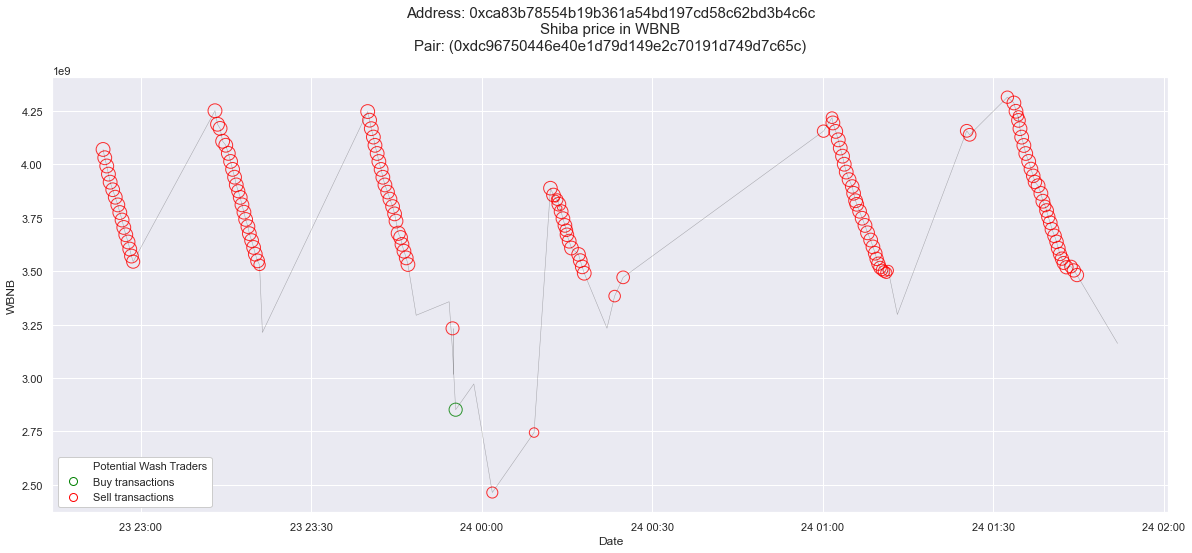

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xca83b78554b19b361a54bd197cd58c62bd3b4c6c,is_buying
491,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23315926,0x4be2ae16171afda7c44bbde5229525ccbfe01eb157c7...,1669244000,5000000000,140556,253,0xcf287cae239c93f128bb4e495a9c6743b375e9ea31ef...,112,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3feac5025a1085d25ced85d226d249c157dcf107,2022-11-23 22:53:20,430000000000000000,0,0,175027133712408763,0.7240,53.0,0.0,3.014196e+19,0.528302,True,0xdc96750446e40e1d79d149e2c70191d749d7c65c,-3.890963e+17,-1.591446e+17,8636726595756677095,0,8636726595756677095,0,21505231757534875946,21505231757534875946,1.376289e-11,5.013404e-12,True,4.070398e+09,2.456762e-10,59.069777,False,False
592,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23315932,0x6d36e10597c5973e712b1a61e30a9c78038929f92aa6...,1669244018,5000000000,125556,266,0x9a2cf97a91e84ce0287341bae04457c4f1c185878d2f...,46,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3feac5025a1085d25ced85d226d249c157dcf107,2022-11-23 22:53:38,430000000000000000,0,0,173357261752819547,0.7240,53.0,0.0,3.014196e+19,0.528302,True,0xdc96750446e40e1d79d149e2c70191d749d7c65c,-3.890963e+17,-1.591446e+17,8636726595756677095,0,8636726595756677095,0,21505231757534875946,21505231757534875946,1.376289e-11,5.013404e-12,True,4.031564e+09,2.480427e-10,59.065790,False,False
694,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23315939,0x30870bb9408dd4b0cbe364854d85dbdc1c1541e21cdd...,1669244039,5000000000,125556,139,0xad3b9391bbdbd8c92d13207c2b638067ab5437000dec...,47,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3feac5025a1085d25ced85d226d249c157dcf107,2022-11-23 22:53:59,436400000000000000,0,0,174254587060064619,0.7240,53.0,0.0,3.014196e+19,0.528302,True,0xdc96750446e40e1d79d149e2c70191d749d7c65c,-3.890963e+17,-1.591446e+17,8636726595756677095,0,8636726595756677095,0,21505231757534875946,21505231757534875946,1.376289e-11,5.013404e-12,True,3.993002e+09,2.504382e-10,59.083134,False,False
782,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23315945,0x0f006396f22cd1a1866a98742c8c62a814237eeff3a8...,1669244057,5000000000,125556,240,0xede0d575a56631b72fd8618d08bbcf49f45133d2651e...,80,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3feac5025a1085d25ced85d226d249c157dcf107,2022-11-23 22:54:17,435400000000000000,0,0,172189960118664064,0.7240,53.0,0.0,3.014196e+19,0.528302,True,0xdc96750446e40e1d79d149e2c70191d749d7c65c,-3.890963e+17,-1.591446e+17,8636726595756677095,0,8636726595756677095,0,21505231757534875946,21505231757534875946,1.376289e-11,5.013404e-12,True,3.954753e+09,2.528603e-10,59.075876,False,False
848,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0x00000000000000000000000000000000000000000000...,23315951,0x2dcab602753260cf2dd09a88c299071c377f11a4ef68...,1669244075,5000000000,125556,123,0x78e133a73aa82be0bd8fdf175e6f619e53baa4d22f85...,63,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3feac5025a1085d25ced85d226d249c157dcf107,2022-11-23 22:54:35,435100000000000000,0,0,170433378645707287,0.7240,53.0,0.0,3.014196e+19,0.528302,True,0xdc96750446e40e1d79d149e2c70191d749d7c65c,-3.890963e+17,-1.591446e+17,8636726595756677095,0,8636726595756677095,0,215052317575348759

7
Swapper contract: 0x7aa84f9953491f47993955d4c0900eab9cc99d77
Pair contract address: 0xfa5fb4005091752afcca2716e607084c581479af


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
7,3.742271e+20,True,True,True,0.0,39.530895,NaN,NaN,NaN,3.742252e+20,NaN,NaN,NaN,5.270778,NaN,NaN,NaN


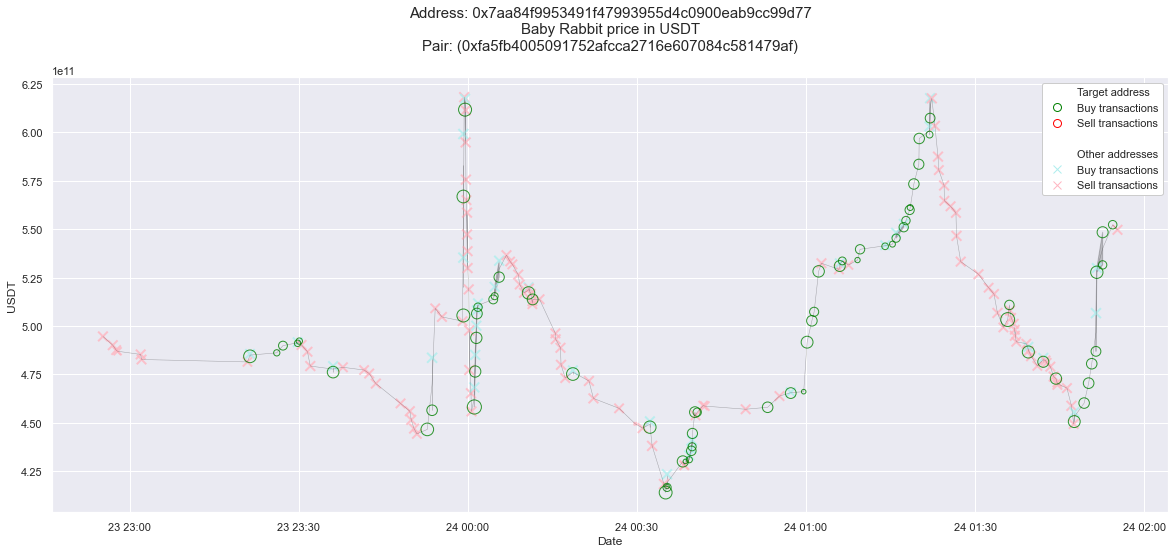

60.942521989644405
1.9936914023747503
64.63160650600099
3.872943529782521
208


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x7aa84f9953491f47993955d4c0900eab9cc99d77,is_buying
15358,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317109,0x782bf1e9a72b972d81853c9149b22bc4d7de7a30da19...,1669247619,6000000000,287486,55,0x6d6bbae2c0834e9670e0ccb58b42a1f85ecc90d5982b...,26,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x021083e6ef827930c799932bd0e9bdaaf90e9d43,2022-11-23 23:53:39,0,2680580428157503,554313266164636324156,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.835858e+11,2.067885e-12,68.909270,False,True
16929,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317220,0x41f1481642f12705f84e94f112ba107f5eb6a40dc99b...,1669247952,5010000000,287486,67,0x285bf65012c8229b45afbc1dca1288d49b9db29c3a6b...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x66941bc0d5f1d3ddc8dba442633a9042a3e13cb6,2022-11-23 23:59:12,0,2726918710940662,509405339835664885496,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.353141e+11,1.868062e-12,68.787384,False,True
16931,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317220,0x41f1481642f12705f84e94f112ba107f5eb6a40dc99b...,1669247952,5010000000,260402,84,0x19ec9f1fd706ab2b82956c46cb596304c774fc160a88...,19,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x7429841363150eb42985a49a154e93016ff926af,2022-11-23 23:59:12,0,2792834331043201,466126109422916017332,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.991585e+11,1.669007e-12,68.659291,False,True
16977,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317223,0xa3eae249f64a498b71419a7e378cdb4369308d62bb26...,1669247961,7000000000,145230,13,0xbe6a60fa40af03cdc839060fa240374fb5d0f14531b1...,3,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xaf44c31b90c8062ebbe86b82ffb40518676e82ad,2022-11-23 23:59:21,150327787939865790758,0,0,929284294825353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.181720e+11,1.617673e-12,67.026683,False,False
17091,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317229,0x13f111bfd9ac940f1873fb682d2045782f226c5b7bf9...,1669247979,6000000000,160206,9,0xf57ea1752c9e40b7b239d29e53f478d02aabbb7fd982...,2,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xa76f9f60da8636969e0ad5ad36d2d3197a90ce51,2022-11-23 23:59:39,150000000000000000000,0,0,863376286071250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.755842e+11,1.737365e-12,67.023533,False,False
17289,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317241,0x22d7d34a81cd09d7e1846855f36ef54bd67039b67d04...,1669248015,7000000000,160206,16,0x525f0f1f6ef708063a8545c373ac3ba85c67cac940d1...,4,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x5a4df742b3ec366d74758d1e0ebae4daab89c999,2022-11-24 00:00:15,300400000000000000000,0,0,1495088571646371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.976993e+11,2.009246e-12,68.025454,False,False
17408,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23317247,0x20173ff592fa129f4baebe983a714942613443732b5f...,16692

191
91
['0x3fd22d7485d1afa12efff4a151fe5a2fc25d785d'
 '0x43c0fbdf3441ccc6069ce9ddeed75438163c75c0'
 '0xc4e0302c31f75ecb6dc3ec7295ebe1dc166dc49c'
 '0x72510f71a01e895ea39c6d4d29b8eb9d7fd65fbd'
 '0x631b87696c80a8e4d3da5dd823dc0bc7ed659a39'
 '0x7faa739ca41c3d09331c22d6cc00d6756ad1bcb3'
 '0x7aa84f9953491f47993955d4c0900eab9cc99d77'
 '0x8e217e92aecfc169fea97075663ce8ce8168fd35'
 '0x55e7555475c40a1133c43ee2b363c64b6ea782c3'
 '0x51fce4d94bb2032b1bb0d50a2e5f39aa2951ac2a'
 '0x38e8fed86d2fde4c24c9a33d7afeea8ae474b564'
 '0x071742b5eb911fdd95aaf6b4f126426cd07e5e5d'
 '0xc003638815188e26f725f3a35a03a3f701a06d35'
 '0x75be676bbf85fbdd2fe0b21e7c5f69b482826eeb'
 '0x9916af8a1a48510db77974cece1193f5d074fa54'
 '0xa7a657e528265ff44b9e59a81c1cd4a16658e15b'
 '0xc20787f0b224a4c8008bae56fa01443e79da3706'
 '0xf5c3396bef3915771382c2a09eeeb2348ae0f20a'
 '0x0640d5397f5ce9dda87d9b74d450982713ea0962'
 '0xdf0d1c15f1c286fc7cb88fee71ffc43cd96d9267'
 '0x7bba30f68c356f5d212cfe00efd95fac8e94af7f'
 '0x8c1b4f2f0e1f8aa97991ee5

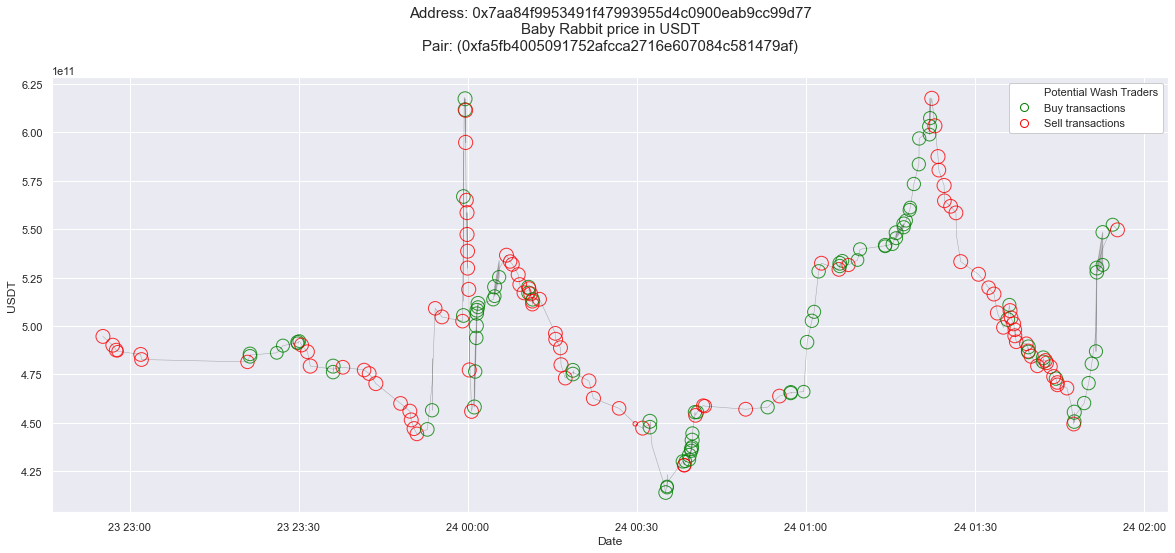

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x7aa84f9953491f47993955d4c0900eab9cc99d77,is_buying
1022,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23315964,0x50c22c63b8297c7c4947c2483282559636da04738ec9...,1669244114,5000000000,160194,214,0x28e0578bfb0cb1c441befc640a6bd24c6087faa52d67...,72,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x3fd22d7485d1afa12efff4a151fe5a2fc25d785d,2022-11-23 22:55:14,50000000000000000000,0,0,247304851451162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.946097e+11,2.021796e-12,65.438569,False,False
1483,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23315999,0x951ae1bdf028cc3485174838602fc9a04ece28e593f6...,1669244219,7000000000,477195,52,0x504d998eb1716c8b32954f5540610dbdf098654d2f51...,11,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x43c0fbdf3441ccc6069ce9ddeed75438163c75c0,2022-11-23 22:56:59,37866625087181228087,0,0,185577247087108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.900813e+11,2.040478e-12,65.037568,False,False
1621,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23316011,0x6e8ea04b37cf100ce61a2a49a958148965e72f2f3f1d...,1669244255,5500000000,223754,24,0xc8cf7004c9adca5709002dbb021aeb753658d6f0a154...,8,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xc4e0302c31f75ecb6dc3ec7295ebe1dc166dc49c,2022-11-23 22:57:35,11764600880470577886,0,0,57358164729248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.875488e+11,2.051077e-12,63.351093,False,False
1668,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23316016,0x2cb2e99583af9ccf6e3489317462067532e2b852192f...,1669244270,7000000000,462171,38,0x95fe3ca84528d09bd27870cfcdafedcac4a29a83f82c...,8,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x43c0fbdf3441ccc6069ce9ddeed75438163c75c0,2022-11-23 22:57:50,3794947697670154,0,0,18479535549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.869510e+11,2.053595e-12,51.753008,False,False
2723,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23316098,0x163df9bfa8a39f96c0176fb6c55f4f55e05faa10f273...,1669244516,5000000000,218504,265,0xd6f401ef46bf79120d49c49da59613a3964e677b62c6...,112,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x72510f71a01e895ea39c6d4d29b8eb9d7fd65fbd,2022-11-23 23:01:56,32467305275981177486,0,0,157568163514307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.853133e+11,2.060524e-12,64.815628,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50770,0xfa5fb4005091752afcca2716e607084c581479af,0x00000000000000000000000000000000000000000000...,23319421,0xb3551c12705f3e6e7d7732fd7485170e3a31d7e0ab58...,1669254697,7000000000,272474,47,0x08d84ead4b6849d1873d2d8e4e34e12c5d1bc29c6d5f...,20,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x99fc6d338ce1ee2986fa7d810f2f2ef869d98494,2022-11-24 01:51:37,0,143582573632888,27094442217326602906,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.299337e+11,1.887029e-12,64.554638,False,True
51107,0xfa5f

8
Swapper address: 0x1525c598acdd96d9c918f5d09d42278fa17d13e6
Pair contract address: 0x7d73c53b7d47ecaadab26d54185b75099341e110


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
8,1.03,True,False,True,0.02,NaN,NaN,NaN,-0.00022,NaN,NaN,NaN,1.237230e+17,NaN,NaN,NaN,0.001875


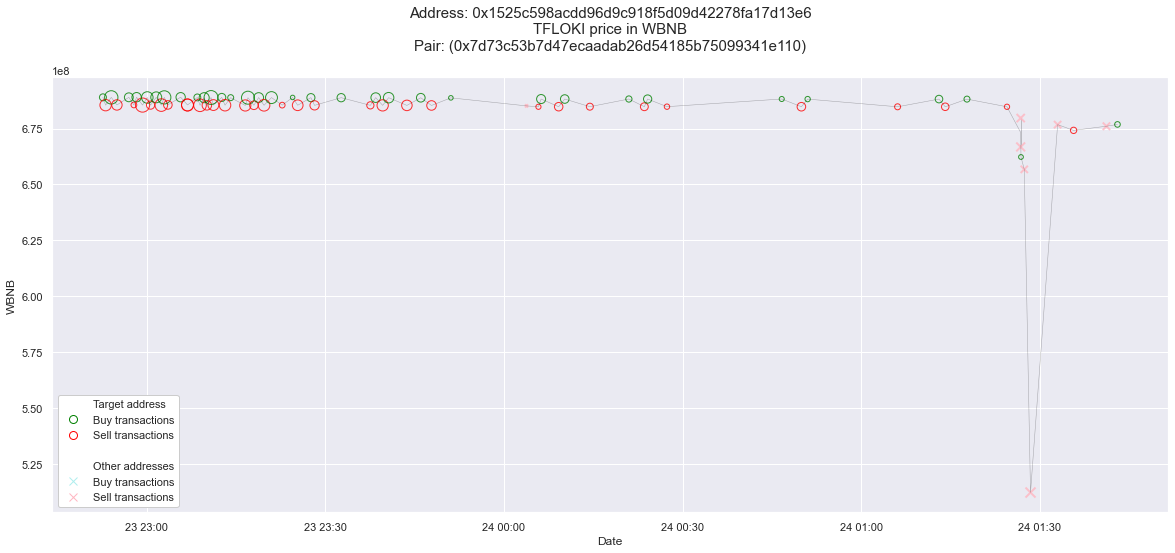

80.06624087963972
0.2590534657032011
84.50223702579788
1.9919750215638439
73


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x1525c598acdd96d9c918f5d09d42278fa17d13e6,is_buying
18502,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23317312,0x888b024c3a9a688b473fdb54ce63565a093dbfe04937...,1669248228,7000000000,223454,44,0x6ed05fa2a83107e390cf564478850ccdede7191248a3...,22,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x4751067aec62a6eda3ec7ecc1a7ff57cdfc6ae53,2022-11-24 00:03:48,3343621112134942,0,0,2290764003814636460004262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.851147e+08,1.459610e-09,80.922103,False,False
42403,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23318938,0x5d106046d0afc16a6745fe6963015ebc593ac17f6d84...,1669253206,5000000198,157946,12,0x706476250599e5d1a04e6b604674f5d0aa7b78314b0b...,7,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xab6310b5f7de140019087c9c7120fb9706e0a154,2022-11-24 01:26:46,60000000000000000,0,0,40779825248512088347018414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.796638e+08,1.471316e-09,85.076058,False,False
42406,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23318938,0x5d106046d0afc16a6745fe6963015ebc593ac17f6d84...,1669253206,5000000000,145874,51,0x0c120fe02747c68079189016e06b19b2c8d8e08a3ea9...,21,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x4c4f50df03a78eb61625e02556662d49540bbe07,2022-11-24 01:26:46,100000000000000000,0,0,66675728530394272426472983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.667573e+08,1.499796e-09,85.785364,False,False
42596,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23318950,0xb19015437343c330c98ec16183aa7b13bbd2484d71ab...,1669253242,5000000000,151676,311,0xb943acc9d319f292ad5d1fd8f35222cf8347b43f4df7...,169,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x166c78fe32332c406f69e0a179db222d4ac3d3e4,2022-11-24 01:27:22,30000000000000000,0,0,19701942193480992142245932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.567314e+08,1.522693e-09,84.026540,False,False
42881,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23318971,0x877b648788a0007a8986f3504c7af44c5d86e6355a41...,1669253305,7000000000,196382,44,0x3bcfbc3422b380a514cebec8350275fc2a997494d764...,18,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x4751067aec62a6eda3ec7ecc1a7ff57cdfc6ae53,2022-11-24 01:28:25,404497176506624516,0,0,207170273589614062602959595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,5.121674e+08,1.952487e-09,87.420947,False,False
44305,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23319058,0x705def95c45a43380284e5b5c83c505d9a769f97ce6a...,1669253578,5000000000,151676,180,0x8b811d159f3922d5238802d6a3ac3c4a7637d14dbc23...,101,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x166c78fe32332c406f69e0a179db222d4ac3d3e4,2022-11-24 01:32:58,30000000000000000,0,0,20302176880999442852280676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.767392e+08,1.477674e-09,84.069837,False,False
47188,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23319216,0x0c29

66
1
['0x1525c598acdd96d9c918f5d09d42278fa17d13e6']
2.884290681740732e-14
0.00013531759224581042


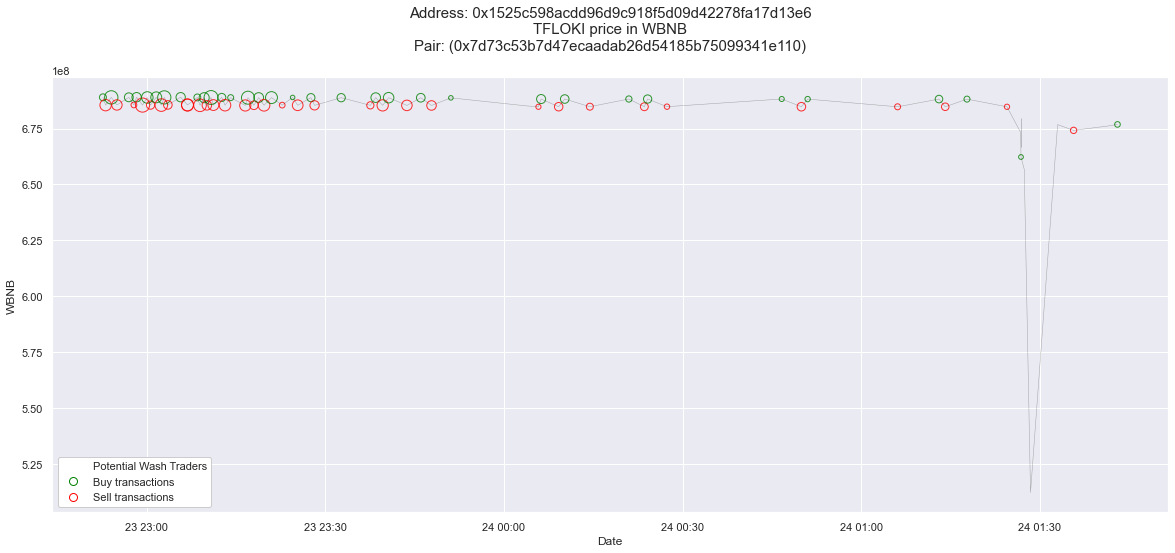

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x1525c598acdd96d9c918f5d09d42278fa17d13e6,is_buying
266,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23315913,0x1a2d19dc118bd8a72433087ba08cf26590c08708351c...,1669243961,5000000000,142592,101,0x12f34673c01fb4c00b454790769d4cf155b46f08f688...,86,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x1525c598acdd96d9c918f5d09d42278fa17d13e6,2022-11-23 22:52:41,0,1101099791511440000000000,1598257761003358,0,0.9016,66.0,0.0,1.033828,0.015152,True,0x7d73c53b7d47ecaadab26d54185b75099341e110,-2.467191e+14,-1.691223e+23,43164601052570000000000000,41752215808892820000000000,84916816861462820000000000,60707935696416452,63015071475148167,123723007171564619,0.000135,2.884291e-14,True,6.889376e+08,1.451510e-09,79.865220,True,True
433,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23315922,0x93ea11e28c9198cb96e939c696bed42c6adea0420741...,1669243988,5000000000,130203,240,0x08fa34aa541251e39710e4d77d926c407640d3dbbb6e...,100,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x1525c598acdd96d9c918f5d09d42278fa17d13e6,2022-11-23 22:53:08,2186543140304012,0,0,1498763960433000000000000,0.9016,66.0,0.0,1.033828,0.015152,True,0x7d73c53b7d47ecaadab26d54185b75099341e110,-2.467191e+14,-1.691223e+23,43164601052570000000000000,41752215808892820000000000,84916816861462820000000000,60707935696416452,63015071475148167,123723007171564619,0.000135,2.884291e-14,True,6.854491e+08,1.458898e-09,80.310047,True,False
718,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23315941,0xee6aaaae1d6cc566e522fba97dfc241201908c5e87ee...,1669244045,5000000000,142604,87,0x467616a6d3129fec30a9053ceb543573b4cd3c5096be...,21,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x1525c598acdd96d9c918f5d09d42278fa17d13e6,2022-11-23 22:54:05,0,1796675761916000000000000,2607943228590246,0,0.9016,66.0,0.0,1.033828,0.015152,True,0x7d73c53b7d47ecaadab26d54185b75099341e110,-2.467191e+14,-1.691223e+23,43164601052570000000000000,41752215808892820000000000,84916816861462820000000000,60707935696416452,63015071475148167,123723007171564619,0.000135,2.884291e-14,True,6.889244e+08,1.451538e-09,80.571604,True,True
968,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23315960,0xcea4519704bb6bae16b59a2fca70e1e36e85551dd877...,1669244102,5000000000,130203,87,0xea65a21e855db09c4ad975c8b8a90df8e2e4753fe000...,26,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x1525c598acdd96d9c918f5d09d42278fa17d13e6,2022-11-23 22:55:02,2009566756631201,0,0,1377627923767000000000000,0.9016,66.0,0.0,1.033828,0.015152,True,0x7d73c53b7d47ecaadab26d54185b75099341e110,-2.467191e+14,-1.691223e+23,43164601052570000000000000,41752215808892820000000000,84916816861462820000000000,60707935696416452,63015071475148167,123723007171564619,0.000135,2.884291e-14,True,6.855348e+08,1.458715e-09,80.188461,True,False
1495,0x7d73c53b7d47ecaadab26d54185b75099341e110,0x00000000000000000000000000000000000000000000...,23316000,0x7c9f6c965c2ad2ad5e1bda9b1e8ae0c45535ee1580ab...,1669244222,5000000000,142604,72,0x47137126921708d7557752acc1c6c55b62a8f44bcffc...,25,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x1525c598acdd96d9c918f5d09d42278fa17d13e6,2022-11-23 22:57:02,0,1232010642592380000000000,1788226086

9
Swapper contract: 0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688
Pair contract address: 0xe44d29b283257e5377a817be605348a500ca37ed


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
9,1.532682e+23,True,True,True,0.05,-31.548025,NaN,NaN,NaN,9.580100e+20,NaN,NaN,NaN,14.515303,NaN,NaN,NaN


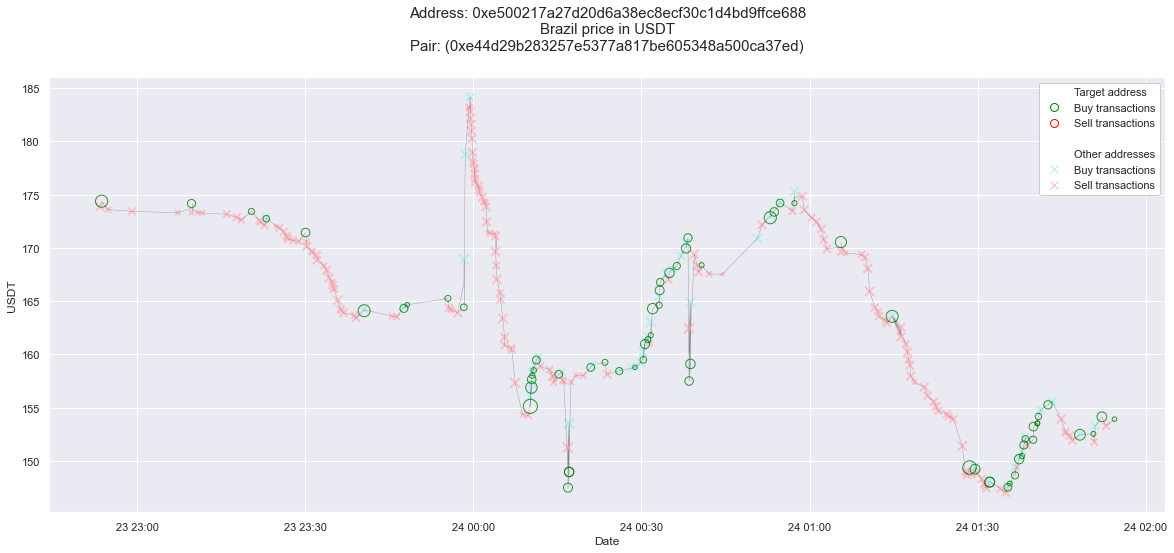

70.4443624334299
1.095426402387273
74.07816762798969
2.2488486274547044
277


,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688,is_buying
477,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23315926,0x4be2ae16171afda7c44bbde5229525ccbfe01eb157c7...,1669244000,5000000000,534522,114,0xb129181c9b2492c6d34983a062e89d43e14826cb6abc...,49,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x15c590ff9bb6ca7cc1023d610faf0da79d8680e3,2022-11-23 22:53:20,320170862493951287686,0,0,55670524590200978432911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,173.877548,0.005751,75.567605,False,False
1985,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316040,0x9cefbd9975072ef36774b5288e2e45c24d72c0d4ba72...,1669244342,5000000000,407462,51,0x12108de04e00388887ae61517a089cdb04368cb763e1...,20,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x89e7d77d640debd0a960992582f53642879a0a36,2022-11-23 22:59:02,100000000000000000000,0,0,17343925975476400156978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,173.439260,0.005766,73.885143,False,False
6479,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316414,0xc308be0474cd1f0af2ba6560f906fc6725a3c843755e...,1669245464,5000000000,499975,179,0xb26d6c46e584b4dcaacd195644a58bb3161e7153c095...,54,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x697dd01a98ec915ed3e134be8edc4de8c9b5d5d2,2022-11-23 23:17:44,147967683624438852398,0,0,25579537445442825812878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,172.872460,0.005785,74.445730,False,False
7466,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316496,0x37b65798b416ad7257f77095b8adcebaa3e7e556a141...,1669245710,5000000000,407369,69,0xd8216fb156334dc62f61266af7251e848c7e22dcc11f...,17,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x29d5bc012719cf0a7bafef0700166d7dbfee3d91,2022-11-23 23:21:50,100000000000000000000,0,0,17256411599891932367195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,172.564116,0.005795,73.877887,False,False
7690,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316514,0x4fceb22d53debca511b7ac33955a886fd6f88f784504...,1669245764,5000000000,422381,128,0x8466074e2d6cc242caf231b7445c46977a0f2741f78a...,41,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x64ee1fabd0e9dc444372131f1dc6beb1c1afc439,2022-11-23 23:22:44,200000000000000000000,0,0,34425958540194791358571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,172.129793,0.005810,74.874272,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48475,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23319291,0x46d5d57eb2b87cb8b028118bbb0810be661193531f02...,1669254295,5010000000,392486,215,0x835bd4283b8041d9c8c1314747b6ce72f66e58165a33...,50,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xce49cd21563c028f20db45f40ee7e9bfd033d139,2022-11-24 01:44:55,1000324501871308004046,0,0,153976057263157336609688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,153.926108,0.006497,77

147
68
['0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688'
 '0x2bf1ecb53b366416a9de72ee2a03d3389551b8e4'
 '0x690f53a158e5b87e0f59d124c46254a7f67e6096'
 '0x7be5c77fd9a39ba833c2cac3a0d42a0d3eb1e682'
 '0xd17e101afd776620cce791e519940cd7c4f1eff7'
 '0x0fa51016e0afb421a47357a09f6f3012c198c9e9'
 '0xcbc7a609baae0ca814b45c755b678c25260ef67d'
 '0x51ca5423ba17e45941c7058c14fcb4efdec0b1b7'
 '0x97f7a4441de0600b53615deda7d3e343a3f72978'
 '0x3373f54c0e3320e2e62fe3d0b18dba201509561e'
 '0xfe44398217b5bc0e3eb9396775be63d630acdff1'
 '0x3f7b4823d3d667a9b0a3fdf2c00600d382355dc6'
 '0x571c865e8785f9d4d9935e361f2e6bd111f72244'
 '0x59557aef2add487bdb4c344aab3d5abf5eef74e3'
 '0x987abcc4e0b84971aaa08879504be0d3a7514af0'
 '0x56b992e924158cd61411a276c0cf6d1c0218d70b'
 '0x362e0cf56ca957a15e6d0a17809e1eaf2438e794'
 '0x99f09e0d4b765b2b280c3de7b894a5b41c316f71'
 '0x20e1576a33ca78b30a0070f0cebbfa2d0885913c'
 '0xc8fad0c61898d5cc5e2508b20783744049009bd8'
 '0xd04e74956bc14ed05553d422cf16a842b82f144c'
 '0xcccf35926da5be4403e806a

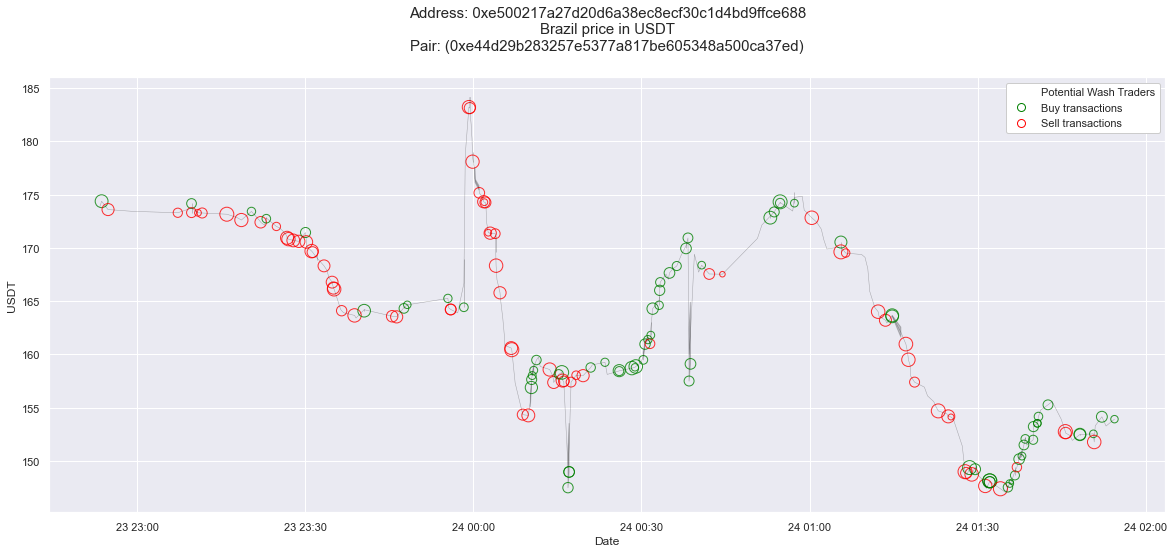

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688,is_buying
578,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23315932,0x6d36e10597c5973e712b1a61e30a9c78038929f92aa6...,1669244018,5500000000,785753,101,0x526f8e7f0cc62d0104332cde247d10a5f9a815cefbab...,15,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688,2022-11-23 22:53:38,0,7069534354403738050000,40539568406980814525,0,0.9016,66.0,0.0,1.532682e+23,0.045455,True,0xe44d29b283257e5377a817be605348a500ca37ed,3.299488e+19,5.432837e+21,0,152310172906925674650000,152310172906925674650000,958009967848527276466,0,958009967848527276466,2.427110e-07,2.233359e-10,True,174.386029,0.005734,72.590355,True,True
924,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23315955,0xa19c84b57a858cea5a7e7580b91fcb21d925208c88c1...,1669244087,5000000000,487960,423,0xbb906a000705e7178e06be559c4cd8191e53099a3b17...,114,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2bf1ecb53b366416a9de72ee2a03d3389551b8e4,2022-11-23 22:54:47,26501027471733027323,0,0,4600643615561763204982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,173.602462,0.005760,71.970612,False,False
4103,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316204,0x168c8936548a1d7bda1b8e1d575713a5a60796c67080...,1669244834,5000000000,478206,60,0x2b8994ee22a491dfd41efd031327d94109f1d565dd42...,12,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x690f53a158e5b87e0f59d124c46254a7f67e6096,2022-11-23 23:07:14,7066088632303906177,0,0,1224560352649738358851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,173.301018,0.005770,70.061055,False,False
4654,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316253,0x5a66a2f0f1a3d1328528e9c629aab609be875d4249d6...,1669244981,5000000000,759591,247,0x20878ff12c9a55d77a972b407a54a5af4120a106e901...,135,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688,2022-11-23 23:09:41,0,1499014993482389240000,8606482508599145914,0,0.9016,66.0,0.0,1.532682e+23,0.045455,True,0xe44d29b283257e5377a817be605348a500ca37ed,3.299488e+19,5.432837e+21,0,152310172906925674650000,152310172906925674650000,958009967848527276466,0,958009967848527276466,2.427110e-07,2.233359e-10,True,174.172781,0.005741,70.352764,True,True
4660,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23316253,0x5a66a2f0f1a3d1328528e9c629aab609be875d4249d6...,1669244981,5000000000,480679,326,0x45355491e47dedd3300f9b16d6049b81bdaffd1dced7...,151,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x7be5c77fd9a39ba833c2cac3a0d42a0d3eb1e682,2022-11-23 23:09:41,9396653436350766568,0,0,1628568096782909910664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,173.313628,0.005770,70.472394,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49678,0xe44d29b283257e5377a817be605348a500ca37ed,0x00000000000000000000000000000000000000000000...,23319358,0xe034a60615f62e8e9574c291420c0630d2c3aebf01c8...,1669254496,5000000000,684


Identified 10 adresses as bots, 4 of which are contracts                                            


,swapper,hour_window,txs_from_address,percent_txs_from_address,txs_in_same_block,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,most_common_pair_address,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,total_token1_volume_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address
0,0x525d4e10e7903b61188c0d5ce54e281c2448e98c,3.028,170.0,2.32,2.0,1.281187e+23,True,False,False,0xbe46815e0f0123ad626b82a0166eaa32274104f5,0.10,833.317151,NaN,NaN,NaN,1779.426800,NaN,NaN,NaN,1.281187e+23,NaN,NaN,NaN,2122123323649,128118743062408634358941,0.00,0.0
1,0x581478e4b12b7cf981dad77eda039a56cbfcc512,3.012,170.0,2.32,55.0,1.250000e+00,True,False,True,0xc67e70025fe4727c58598c560eb2f25b64d3c7e7,0.32,-40.687879,NaN,NaN,NaN,146.102761,NaN,NaN,NaN,2.483747e+22,NaN,NaN,NaN,5043217020923983647455800,24837469315904259759841,0.00,0.0
2,0x020e878018bccebd9459e8f098233b7df1964b7b,2.878,161.0,2.20,12.0,3.391007e+21,True,True,True,0xa527035b53961f83009ef010ae1600afa89b1438,0.02,-46.296046,NaN,NaN,NaN,8.338440,NaN,NaN,NaN,1.342489e+21,NaN,NaN,NaN,1342488828370260693501,2048518452997459367224,0.00,0.0
3,0x597873c70dc1946613d485601c9bdc4608e36f14,3.040,122.0,1.67,2.0,1.719516e+29,True,True,True,0x2315faf6aafe06a06c884d04975059e82be08bf7,0.03,-393.619348,NaN,NaN,NaN,10.290439,NaN,NaN,NaN,1.255434e+21,NaN,NaN,NaN,171951597877053404218361264297,1255433550275623011972,0.27,0.0
4,0x324ec7743a70212299ae82ad674f7547e6b4069d,3.061,90.0,1.23,5.0,1.254302e+22,True,False,False,0x58f876857a02d6762e0101bb5c46a8c1ed44dc16,0.00,NaN,NaN,NaN,-0.392321,NaN,NaN,NaN,0.615809,NaN,NaN,NaN,4.187499e+19,112162792940147797790769,281502382632276108385493,0.00,0.0
5,0xfaeaec036bccbc75fa3aa8a1c97e40a49f44fd64,3.051,78.0,1.07,0.0,1.990000e+00,True,False,True,0xa5f3287f86e59ad59aba7e11f3c2d3ee7ae76086,0.01,NaN,NaN,NaN,0.004612,NaN,NaN,NaN,0.013697,NaN,NaN,NaN,1.068329e+18,1033989720079000000000000,1068328628759640314,0.00,0.0
6,0xca83b78554b19b361a54bd197cd58c62bd3b4c6c,2.821,71.0,0.97,0.0,3.597779e+19,True,False,True,0xdc96750446e40e1d79d149e2c70191d749d7c65c,0.46,NaN,NaN,NaN,1.381045,NaN,NaN,NaN,0.370832,NaN,NaN,NaN,2.632907e+19,9648728693204211604,26329065563219967487,0.00,0.0
7,0x7aa84f9953491f47993955d4c0900eab9cc99d77,2.552,71.0,0.97,3.0,3.742271e+20,True,True,True,0xfa5fb4005091752afcca2716e607084c581479af,0.00,39.530895,NaN,NaN,NaN,5.270778,NaN,NaN,NaN,3.742252e+20,NaN,NaN,NaN,1848526065297445,374225214055092959846,0.00,0.0
8,0x1525c598acdd96d9c918f5d09d42278fa17d13e6,2.839,66.0,0.90,0.0,1.030000e+00,True,False,True,0x7d73c53b7d47ecaadab26d54185b75099341e110,0.02,NaN,NaN,NaN,-0.000220,NaN,NaN,NaN,0.001875,NaN,NaN,NaN,1.237230e+17,84916816861462820000000000,123723007171564619,0.00,0.0
9,0xe500217a27d20d6a38ec8ecf30c1d4bd9ffce688,3.013,66.0,0.90,0.0,1.532682e+23,True,True,True,0xe44d29b283257e5377a817be605348a500ca37ed,0.05,-31.548025,NaN,NaN,NaN,14.515303,NaN,NaN,NaN,9.580100e+20,NaN,NaN,NaN,152310172906925674650000,958009967848527276466,0.00,0.0


In [30]:
# Filter out top adresses by something: sort_values(by=[

# 1) To find most active bots, put:________________by=["percent_txs_from_address"]
# 2) To find predictable market makers, put:_______by=["tx_size_similarity"]
# 3) To find sandwitch bots, put:__________________by=["txs_in_same_block"]

x = df.drop_duplicates(subset = "To").round(2).sort_values(by = ["percent_txs_from_address"], ascending = False, kind = "mergesort").reset_index(drop = True)[:10] # only analyse top 20 addresses by percent_txs_from_address
# print(x.head())
# and check if they are contracts or simple addresses
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

bot_list = unique([i for i in x.To.to_list() if i in set(x.To.to_list())]) # preserves order
# print(bot_list)

if len(bot_list) < 200:
    iteration = 0
    for bot in bot_list:
        print(iteration)
        iteration += 1
        print(f"Analysing top {len(bot_list)} bot addresses. {iteration} out of {len(bot_list)}...", end="\r")

        # check all their txs
        _df = df[df.To == bot] 
        most_common_pair_address = max(set(_df.contract_address.to_list()), key = _df.contract_address.to_list().count) 
        _df = _df[_df.contract_address == most_common_pair_address] 
        # print(pair_info['token0_symbol'], pair_info['token1_symbol'])
        bot_is_contract = address_is_contract(bot, w3) # takes some time
        x.loc[x.To == bot, "address_is_contract"] = bot_is_contract 

        # check hour window that the transactions occurs
        hour_window = (_df.timeStamp.max() - _df.timeStamp.min()) / (60*60)
        x.loc[x.To == bot,"hour_window"] = round(hour_window, 3)

        pair_info = get_pair_info(most_common_pair_address, abi, bsc_scan_api_key, w3) # takes some time
        pair_info["signatures"] = signatures
        
        # Calculation of profits - do it here bcs need pair_info which takes too long to run for every address in df 
        # Get token price, which is simply a ratio of the Swap
        token0_price_in_token1 = pd.to_numeric((_df.amount1In + _df.amount1Out) / (_df.amount0In + _df.amount0Out)) * (10**(pair_info["token0_decimals"] - pair_info["token1_decimals"])) # accounting for token decimals shown in contract
        # _df["token0_price_in_token1"] = token0_price_in_token1
        token1_price_in_token0 = 1 / token0_price_in_token1
        # _df["token1_price_in_token0"] = token1_price_in_token0
        
        # Get current accumulated position
        position_token0 = (_df.amount0Out.sum() - _df.amount0In.sum()) * 10** - pair_info["token0_decimals"]
        position_token1 = (_df.amount1Out.sum() - _df.amount1In.sum()) * 10** - pair_info["token1_decimals"]
        # Get profits in terms of token0 and token1 
        address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
        address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])

        #Get volume of the token0 and token1
        token0_volume = (_df.amount0Out.sum() + _df.amount0In.sum())
        token1_volume = (_df.amount1Out.sum() + _df.amount1In.sum())
        


        for i in ["USDT", "USDC", "BUSD", "WBNB"]:
            x.loc[x.To == bot, f"profit_in_{i}"] = np.nan # default value
            x.loc[x.To == bot, f"mean_tx_size_in_{i}"] = np.nan # default value
            x.loc[x.To == bot, f"volume_in_{i}"] = np.nan # default value

        # When need to know what is the reference coin:
        if pair_info['token0_symbol'] in ["USDT", "USDC", "BUSD", "WBNB"]:
            # show profit in reference token
            x.loc[x.To == bot, f"profit_in_{pair_info['token0_symbol']}"] = address_position_token0

            # check mean swap size in reference token:
            x.loc[x.To == bot, f"mean_tx_size_in_{pair_info['token0_symbol']}"] = (_df.amount0Out.sum() + _df.amount0In.sum())* 10**-pair_info["token0_decimals"] / len(_df)

            # show volume in reference token
            x.loc[x.To == bot, f"volume_in_{pair_info['token0_symbol']}"] = token0_volume

        elif pair_info['token1_symbol'] in ["USDT", "USDC", "BUSD", "WBNB"]:
            # show profit in reference token
            x.loc[x.To == bot, f"profit_in_{pair_info['token1_symbol']}"] = address_position_token1

            # check mean swap size in reference token:
            x.loc[x.To == bot, f"mean_tx_size_in_{pair_info['token1_symbol']}"] = (_df.amount1Out.sum() + _df.amount1In.sum())* 10**-pair_info["token1_decimals"] / len(_df)

            # show volume in reference token
            x.loc[x.To == bot, f"volume_in_{pair_info['token1_symbol']}"] = token1_volume
        
        else:
            print()
            print(f"There is no reference coin in pair {most_common_pair_address}? {pair_info['token0_symbol']} vs {pair_info['token1_symbol']}")
        
        if bot_is_contract:
            print(f"Swapper contract: {bot}")

        else:
            print(f"Swapper address: {bot}")

        print(f"Pair contract address: {most_common_pair_address}")
        
        display(x.loc[x.To == bot][[
            "position_ratio",
            "potential_wash_trading_bot",
            "address_is_contract",
            "focused_on_single_pair",
            "tx_size_similarity",
            # "USDT",
            # "BUSD",
            # "WBNB",
            "profit_in_USDT",
            "profit_in_USDC",
            "profit_in_BUSD",
            "profit_in_WBNB",
            "volume_in_USDT",
            "volume_in_USDC",
            "volume_in_BUSD",
            "volume_in_WBNB",
            "mean_tx_size_in_USDT",
            "mean_tx_size_in_USDC",
            "mean_tx_size_in_BUSD",
            "mean_tx_size_in_WBNB"]])

        wash_trading = x.loc[x.To == bot, "potential_wash_trading_bot"]

        plot_address_txs(df, bot, pair_info)
        
        if wash_trading.iat[0]:
            find_other_txs_and_analyze_them(df, bot, pair_info)
        # display(df.head(10))
        # break
        # print()

# # Identify potential sandwitch bots based on having any txs_in_same_block and having very balanced position (always buys and sells immediately)
# x["potential_sandwitch_bot"] = False
# x.loc[(x.txs_in_same_block>0) 
# & (x.position_ratio < 1.1)
# , "potential_sandwitch_bot"] = True

# should calculate profits differently if position is balanced.

contract_list = set(x[x.address_is_contract == True].To.to_list())
print()
print(" " * 100, end = "\r")
print(f"Identified {len(bot_list)} adresses as bots, {len(contract_list)} of which are contracts")

x[
["To",
"hour_window",
"txs_from_address",
"percent_txs_from_address",
"txs_in_same_block",
"position_ratio",
"potential_wash_trading_bot",
"address_is_contract",
"focused_on_single_pair",
"most_common_pair_address",
"tx_size_similarity",
# "USDT",
# "BUSD",
# "WBNB",
"profit_in_USDT",
"profit_in_USDC",
"profit_in_BUSD",
"profit_in_WBNB",
"mean_tx_size_in_USDT",
"mean_tx_size_in_USDC",
"mean_tx_size_in_BUSD",
"mean_tx_size_in_WBNB",
"volume_in_USDT",
"volume_in_USDC",
"volume_in_BUSD",
"volume_in_WBNB",
"total_token1_volume_by_address",
"total_token0_volume_by_address",
"percent_token1_volume_by_address",
"percent_token0_volume_by_address",
# "to_address_is_contract",
# "to_address_is_bot",
# "Txhash"
# "profit_in_token0",
# "profit_in_token1"
]].rename(columns = {"To": "swapper"})

## Check address or pair on websites

In [ ]:
# DEX TOOLS

pair_address = "0xe79792f57feb774c98b9c0ae3879e94151bbc6fd"
# open pair in dextools
browser=webbrowser.open(f"https://www.dextools.io/app/bnb/pair-explorer/{pair_address}")

In [ ]:
# BSC SCAN

# for address in x.To.to_list():
address = "0x8b8278b399755c8a1118a61e09efaac75ecd7f9e"
browser=webbrowser.open(f"https://bscscan.com/address/{address}#tokentxns")